In [2]:
import pandas as pd
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import talib
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
from matplotlib.pylab import date2num
import numpy as np


ImportError: cannot import name 'isna'

In [4]:
!pip3 show pandas

Name: pandas
Version: 0.24.0
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: http://pandas.pydata.org
Author: None
Author-email: None
License: BSD
Location: /home/ai-user/anaconda3/envs/py36/lib/python3.6/site-packages
Requires: pytz, python-dateutil, numpy
Required-by: zipline, yfinance, trading-calendars, ta, stocknews, statsmodels, seaborn, pandas-datareader, mplfinance, empyrical


## Define the pool of stocks that are being watched

In [2]:
stock_lst = ['0700.HK','3606.HK','1211.HK','3690.HK','2800.HK','000001.SS','MU','ADBE','SPOT','LOW','TSLA','UNH','NFLX','9988.HK','MSFT','1810.HK','9988.HK','0839.HK','603501.SS','688981.SS','002371.SZ','600703.SS']
stock_name = ['Tencent','Fuyao','BYD','Meituan','Tracker Fund','Shanghai Composite Index','Micron','ADOBE','SPOTIFY','Lowes Cos','TESLA','Unitedhealth Group','Netflix','AliBaba','MSFT','Xiaomi','AliBaba_HK','ChinaEducation','Weier Gufen','Zhongxin Guoji','Beifang Huachuang','Sanan Guangdian']
#stock_lst = ['0981.HK']
#stock_name = ['SMIC']

## Collect and store data

In [3]:
# Get today's date as UTC timestamp
today = datetime.today().strftime("%d/%m/%Y")
today = datetime.strptime(today + " +0000", "%d/%m/%Y %z")
to = int(today.timestamp())
# Get date ten years ago as UTC timestamp, 10 years from now
ten_yr_ago = today-relativedelta(years=10)
fro = int(ten_yr_ago.timestamp())

In [4]:
def get_price_hist(ticker):

    # Put stock price data in dataframe
    url = "https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={fro}&period2={to}&interval=1d&events=history".format(ticker=ticker, fro=fro, to=to)
    data = pd.read_csv(url)
    
    # Convert date to timestamp and make index
    data.index = data["Date"].apply(lambda x: pd.Timestamp(x))
    data.drop("Date", axis=1, inplace=True)

    return data

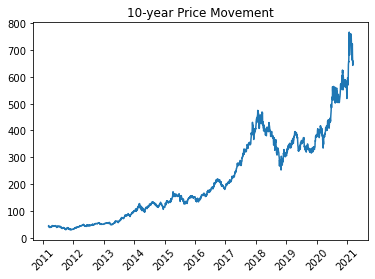

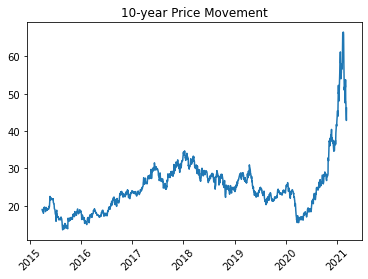

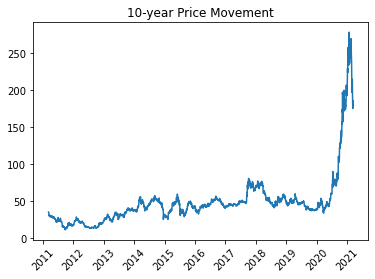

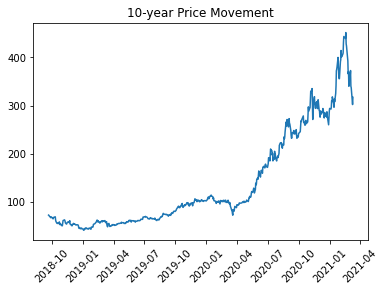

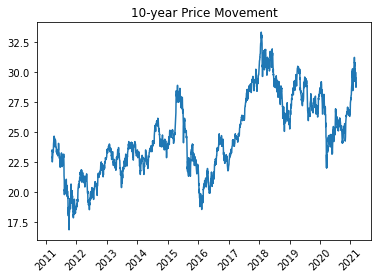

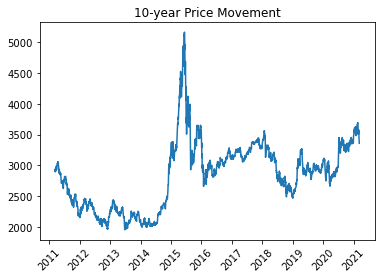

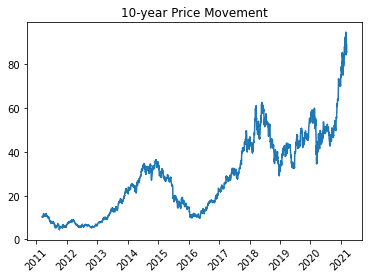

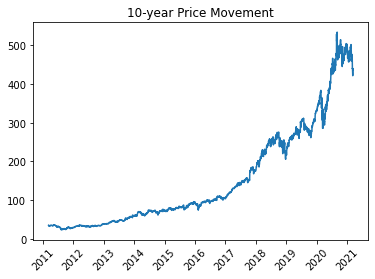

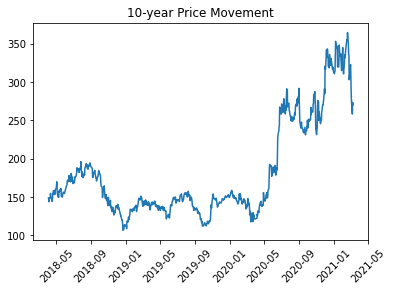

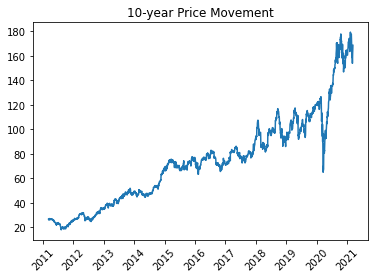

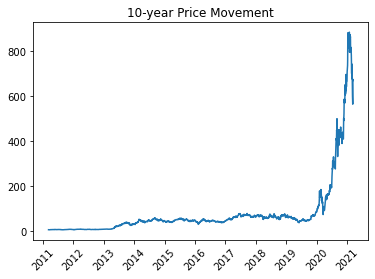

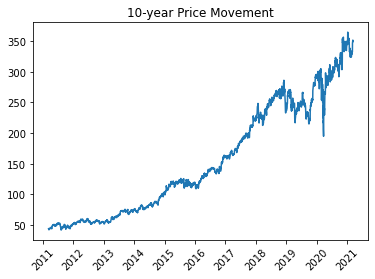

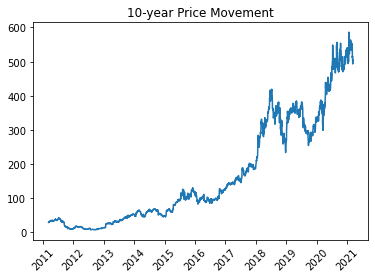

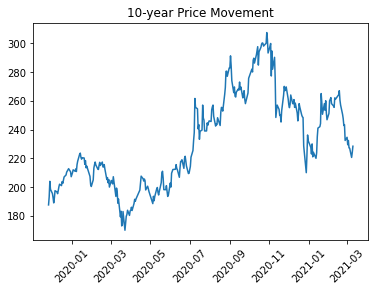

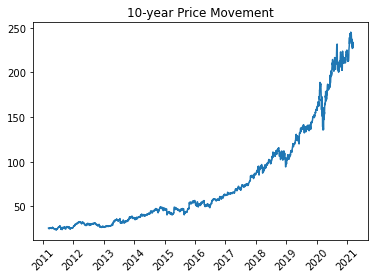

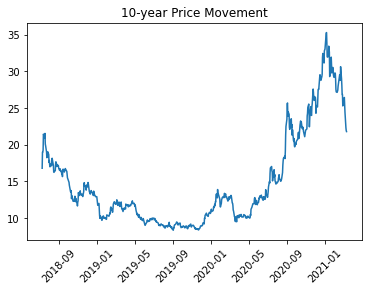

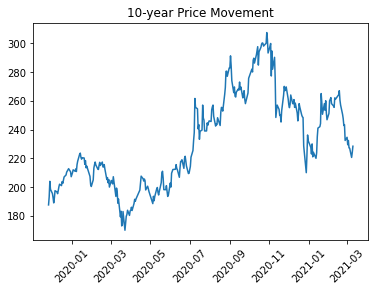

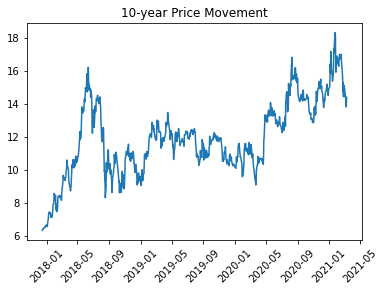

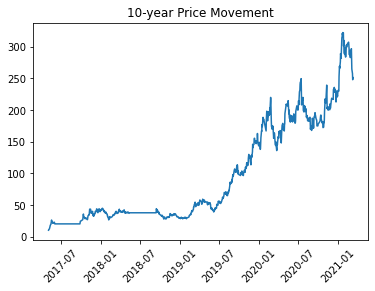

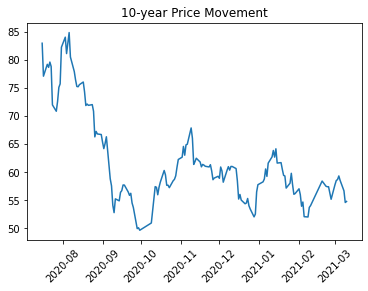

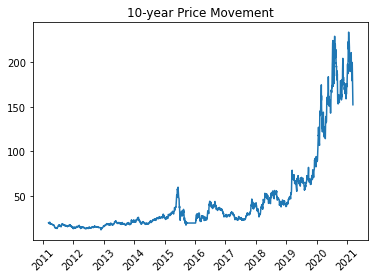

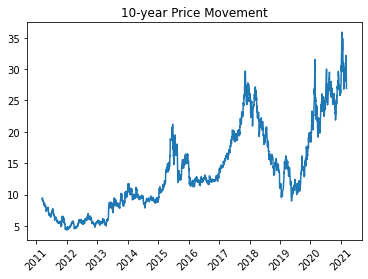

In [5]:
# create folders at current working directory to store all subsequent figures and stats 
import os
i=0
dfs = []
for stock in stock_name:
    ticker = stock_lst[i]
    if not os.path.exists(stock):
        os.makedirs(stock)
    price_df = get_price_hist(ticker)
    price_df = price_df.dropna(axis=0)
    os.chdir(stock)
    plt.plot(price_df['Close'])
    plt.title('10-year Price Movement')
    plt.xticks(rotation=45)
    plt.savefig('10-year price.png')
    plt.show()
    os.chdir("..")
    dfs.append(price_df)
    i=i+1

## Calculate indicators

In [6]:
def get_indicators(data):
    # Get MACD
    data["macd"], data["macd_signal"], data["macd_hist"] = talib.MACD(np.array(data['Close']))
    
    # Get MA10 and MA30
    data["ma10"] = talib.MA(np.array(data["Close"]), timeperiod=10)
    data["ma30"] = talib.MA(np.array(data["Close"]), timeperiod=30)
    
    # Get RSI
    data["rsi"] = talib.RSI(np.array(data["Close"]))
    
    # Get Bollinger bands
    upper, middle, lower = talib.BBANDS(np.array(data["Close"]), timeperiod=20,nbdevup=2, nbdevdn=2)
    data['upper'] = upper
    data['lower'] = lower
    data['middle'] = middle
    return data

In [7]:
def plot_chart(data, n, ticker):
    
    # Filter number of observations to plot
    data = data.iloc[-n:]
    
    # Create figure and set axes for subplots
    fig = plt.figure()
    fig.set_size_inches((20, 16))
    ax_candle = fig.add_axes((0, 0.96, 1, 0.32))
    ax_macd = fig.add_axes((0, 0.72, 1, 0.2), sharex=ax_candle)
    ax_rsi = fig.add_axes((0, 0.48, 1, 0.2), sharex=ax_candle)
    ax_vol = fig.add_axes((0, 0.24, 1, 0.2), sharex=ax_candle)
    ax_bollinger = fig.add_axes((0, 0, 1, 0.2),sharex=ax_candle)
    
    # Format x-axis ticks as dates
    ax_candle.xaxis_date()
    
    # Get nested list of date, open, high, low and close prices
    ohlc = []
    for date, row in data.iterrows():
        openp, highp, lowp, closep = row[:4]
        ohlc.append([date2num(date), openp, highp, lowp, closep])
 
    # Plot candlestick chart
    ax_candle.plot(data.index, data["ma10"], label="MA10")
    ax_candle.plot(data.index, data["ma30"], label="MA30")
    candlestick_ohlc(ax_candle, ohlc, colorup="g", colordown="r", width=0.8)
    ax_candle.legend()
    
    # Plot MACD
    ax_macd.plot(data.index, data["macd"], label="macd")
    ax_macd.bar(data.index, data["macd_hist"] * 3, label="hist")
    ax_macd.plot(data.index, data["macd_signal"], label="signal")
    ax_macd.legend()
    
    # Plot RSI
    # Above 70% = overbought, below 30% = oversold
    ax_rsi.set_ylabel("(%)")
    ax_rsi.plot(data.index, [70] * len(data.index), label="overbought")
    ax_rsi.plot(data.index, [30] * len(data.index), label="oversold")
    ax_rsi.plot(data.index, data["rsi"], label="rsi")
    ax_rsi.legend()
    
    #Plot Bollinger
    ax_bollinger.plot(data.index,data['Close'],label='price')
    ax_bollinger.plot(data.index,data['lower'],label='lower')
    ax_bollinger.plot(data.index,data['upper'],label='upper')
    ax_bollinger.plot(data.index,data['middle'],label='middle')
    ax_bollinger.legend()
    
    # Show volume in millions
    ax_vol.bar(data.index, data["Volume"] / 1000000)
    ax_vol.set_ylabel("(Million)")
   
    # Save the chart as PNG
    fig.savefig('Technical analysis '+ ticker + ".png", bbox_inches="tight")
    
    plt.show()


In [8]:
os.getcwd()

'/media/sf_VM_Share_Folder/Stock analysis'

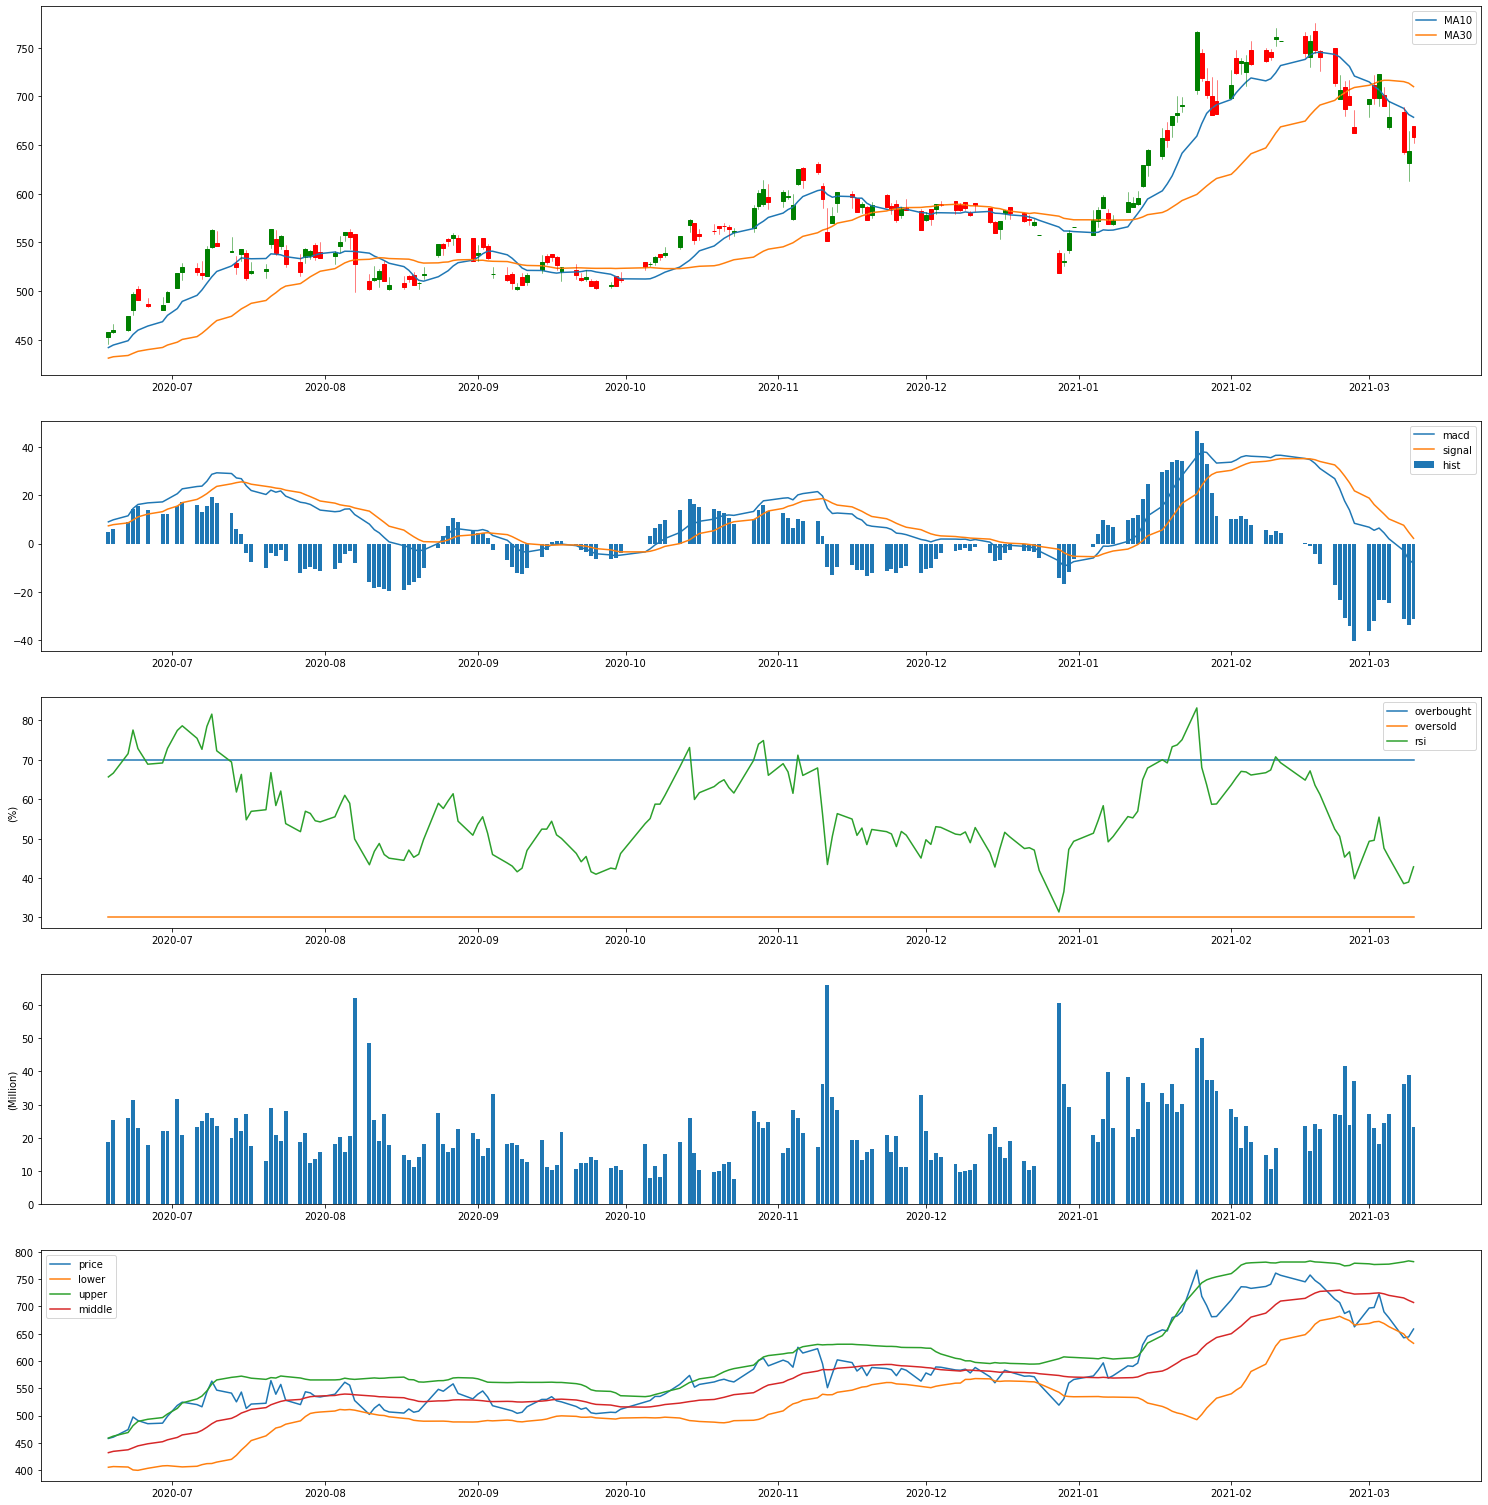

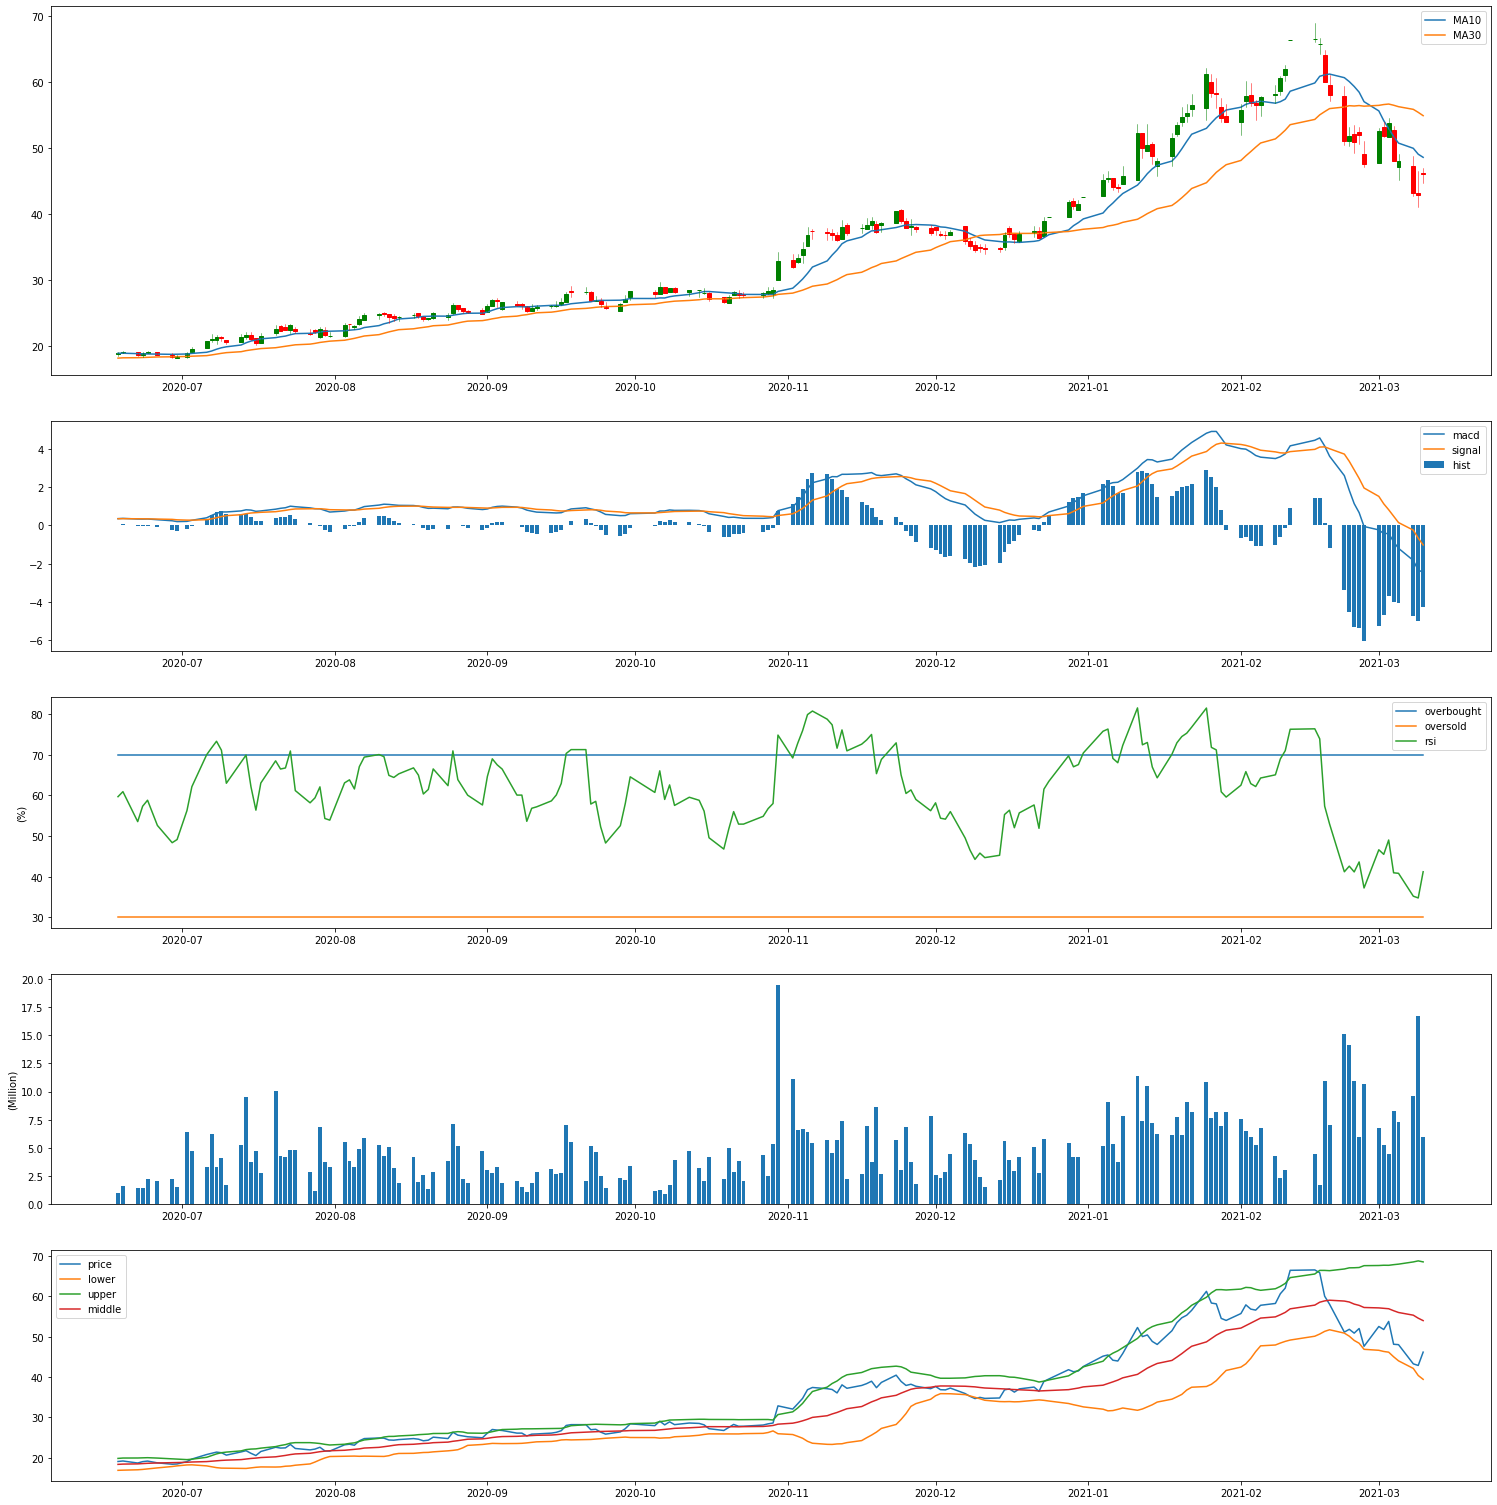

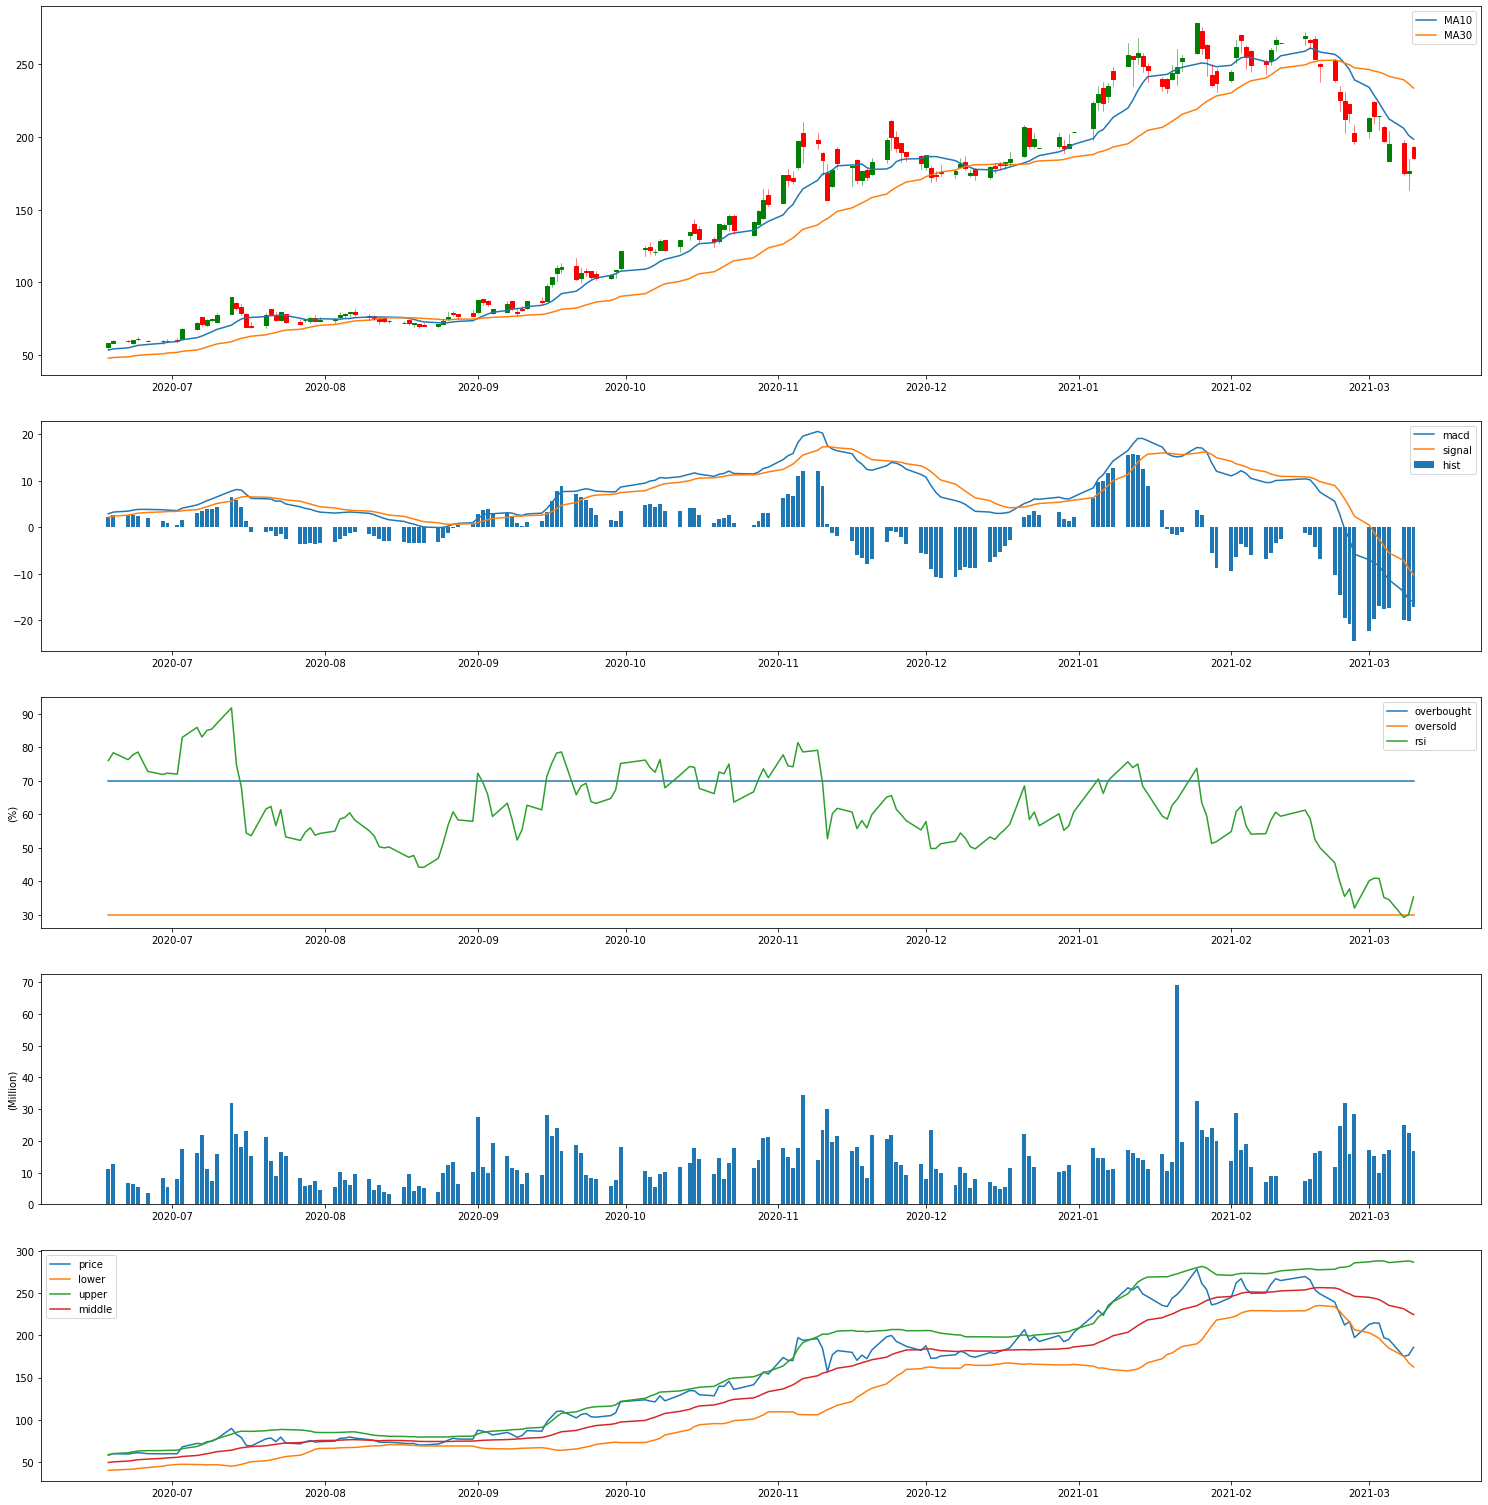

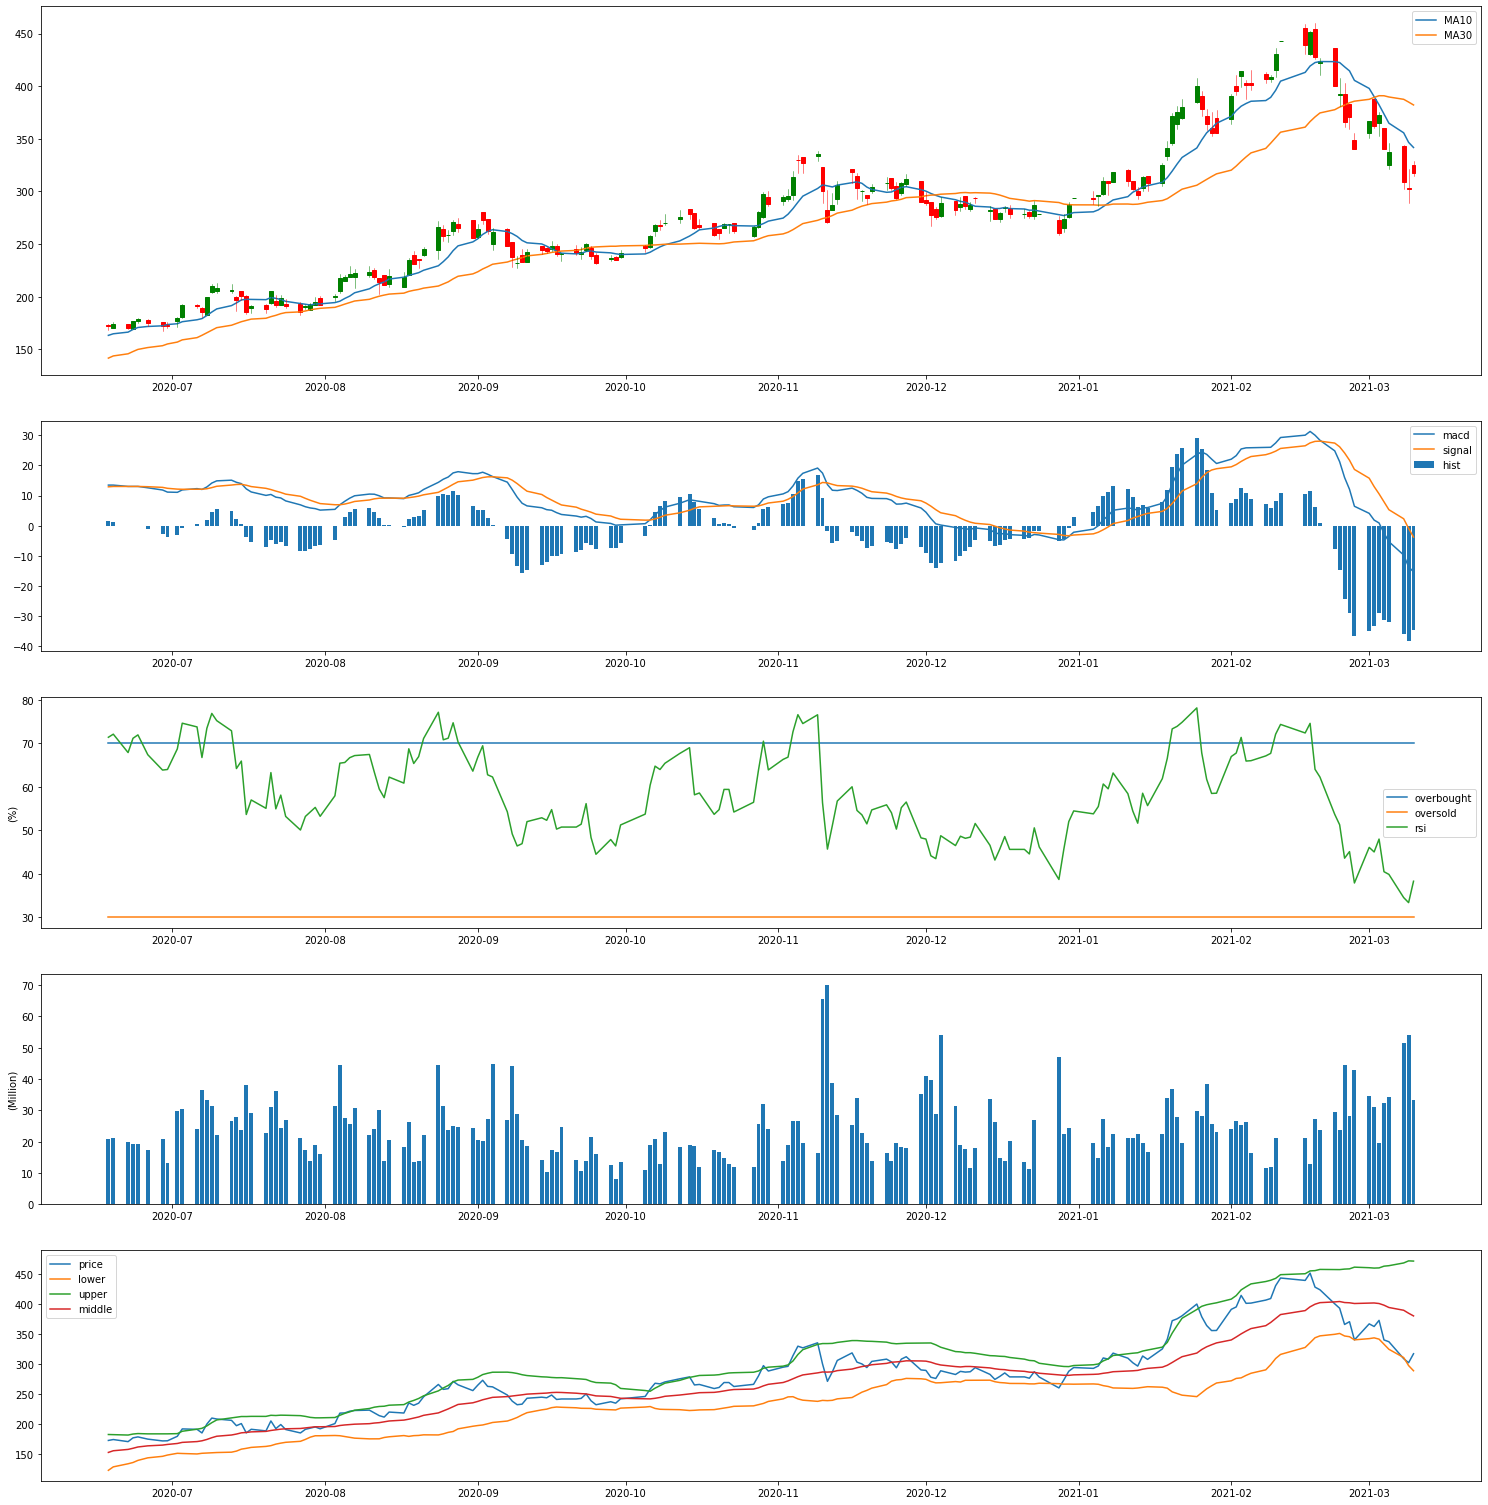

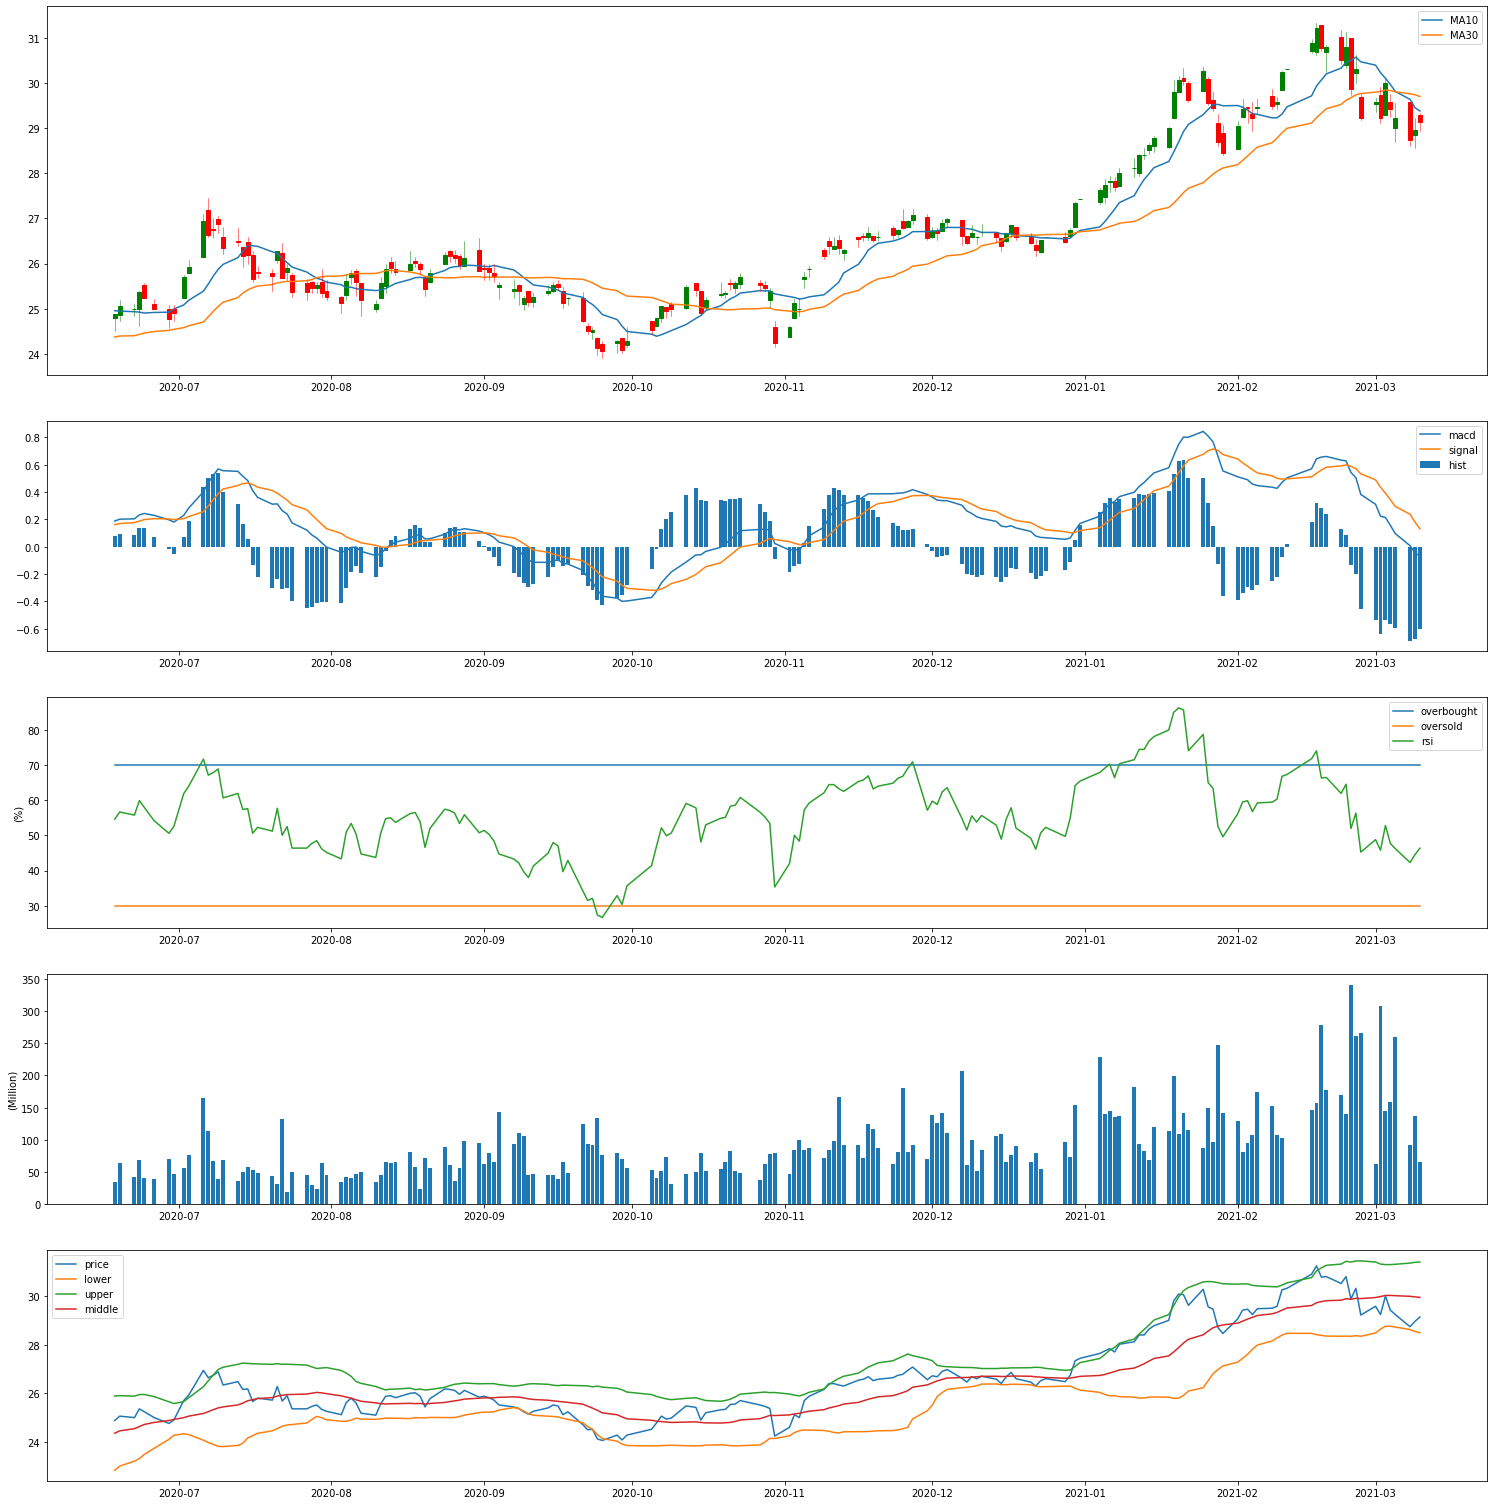

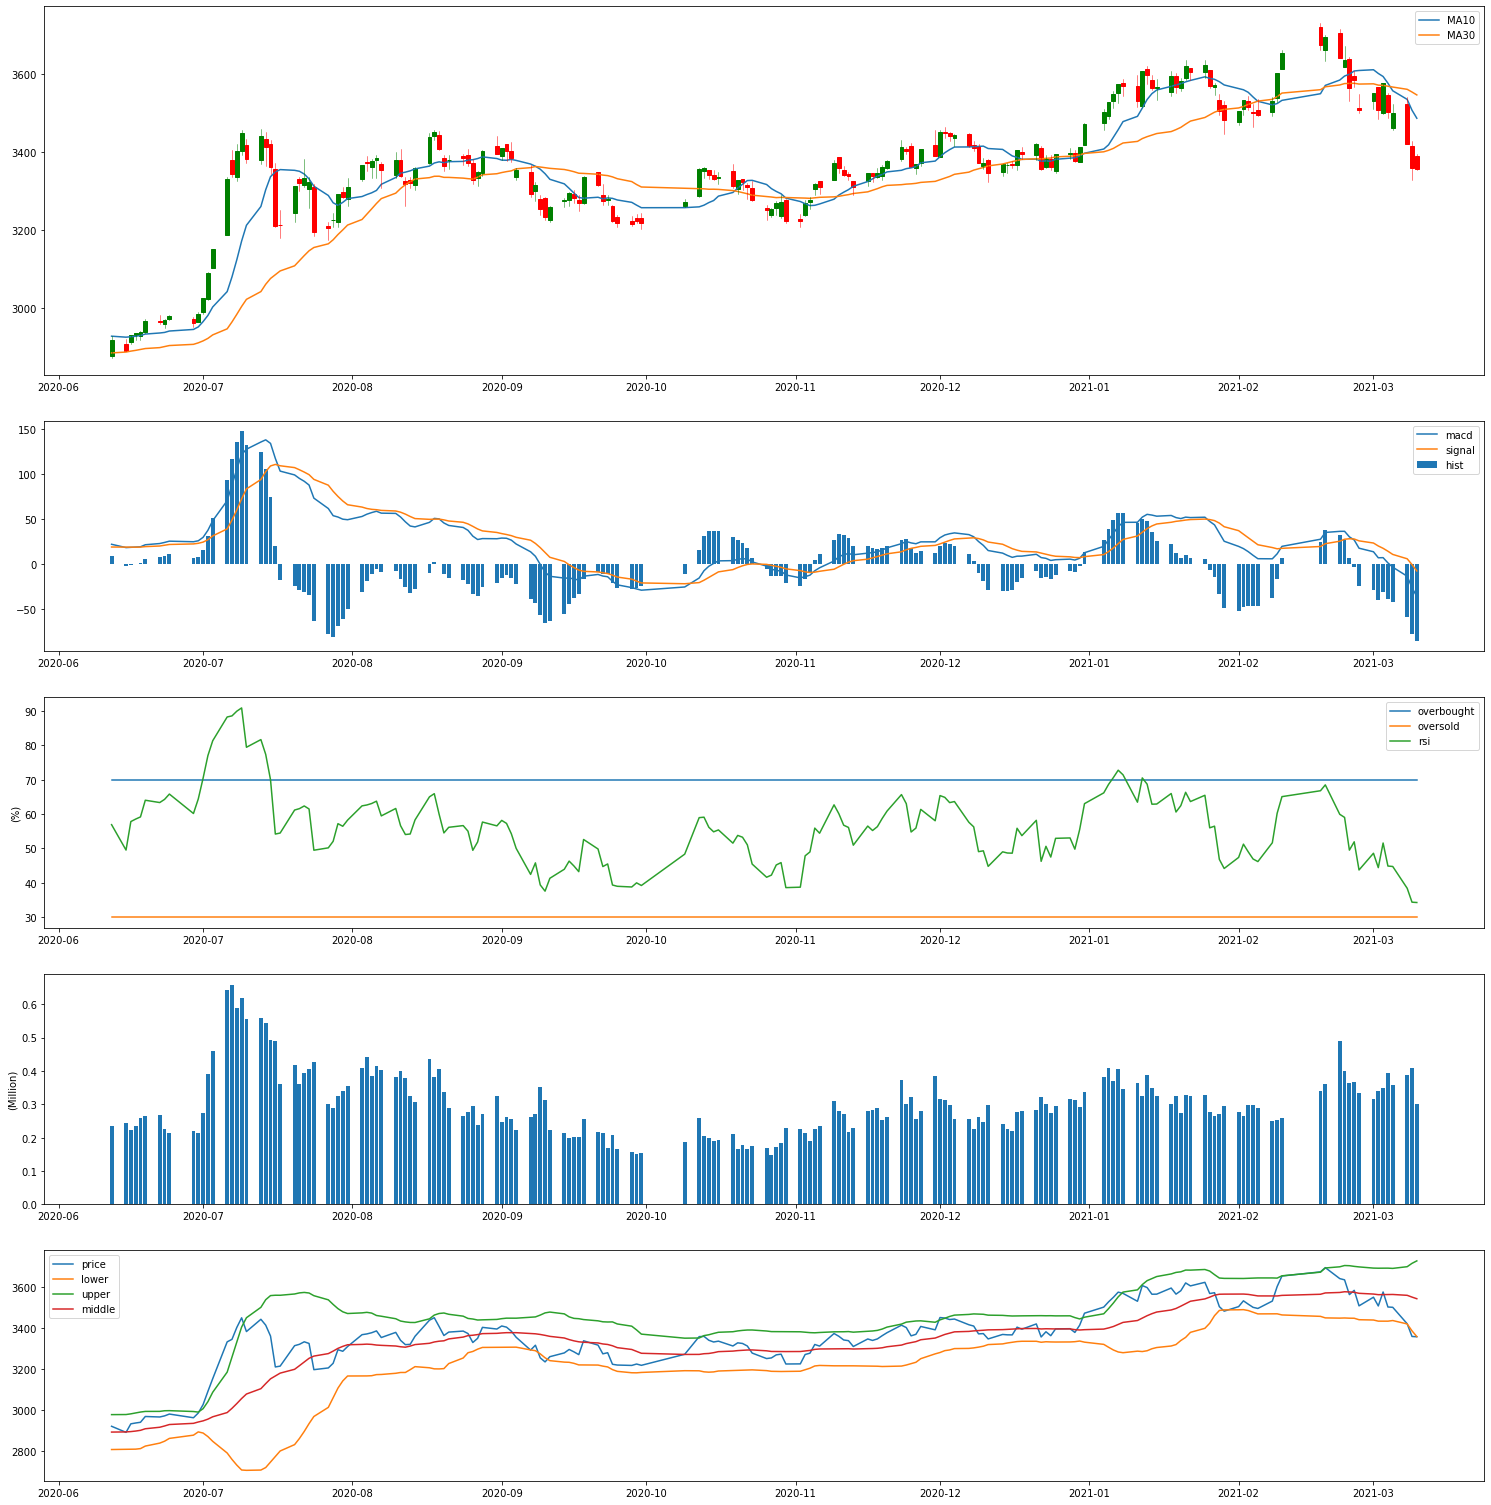

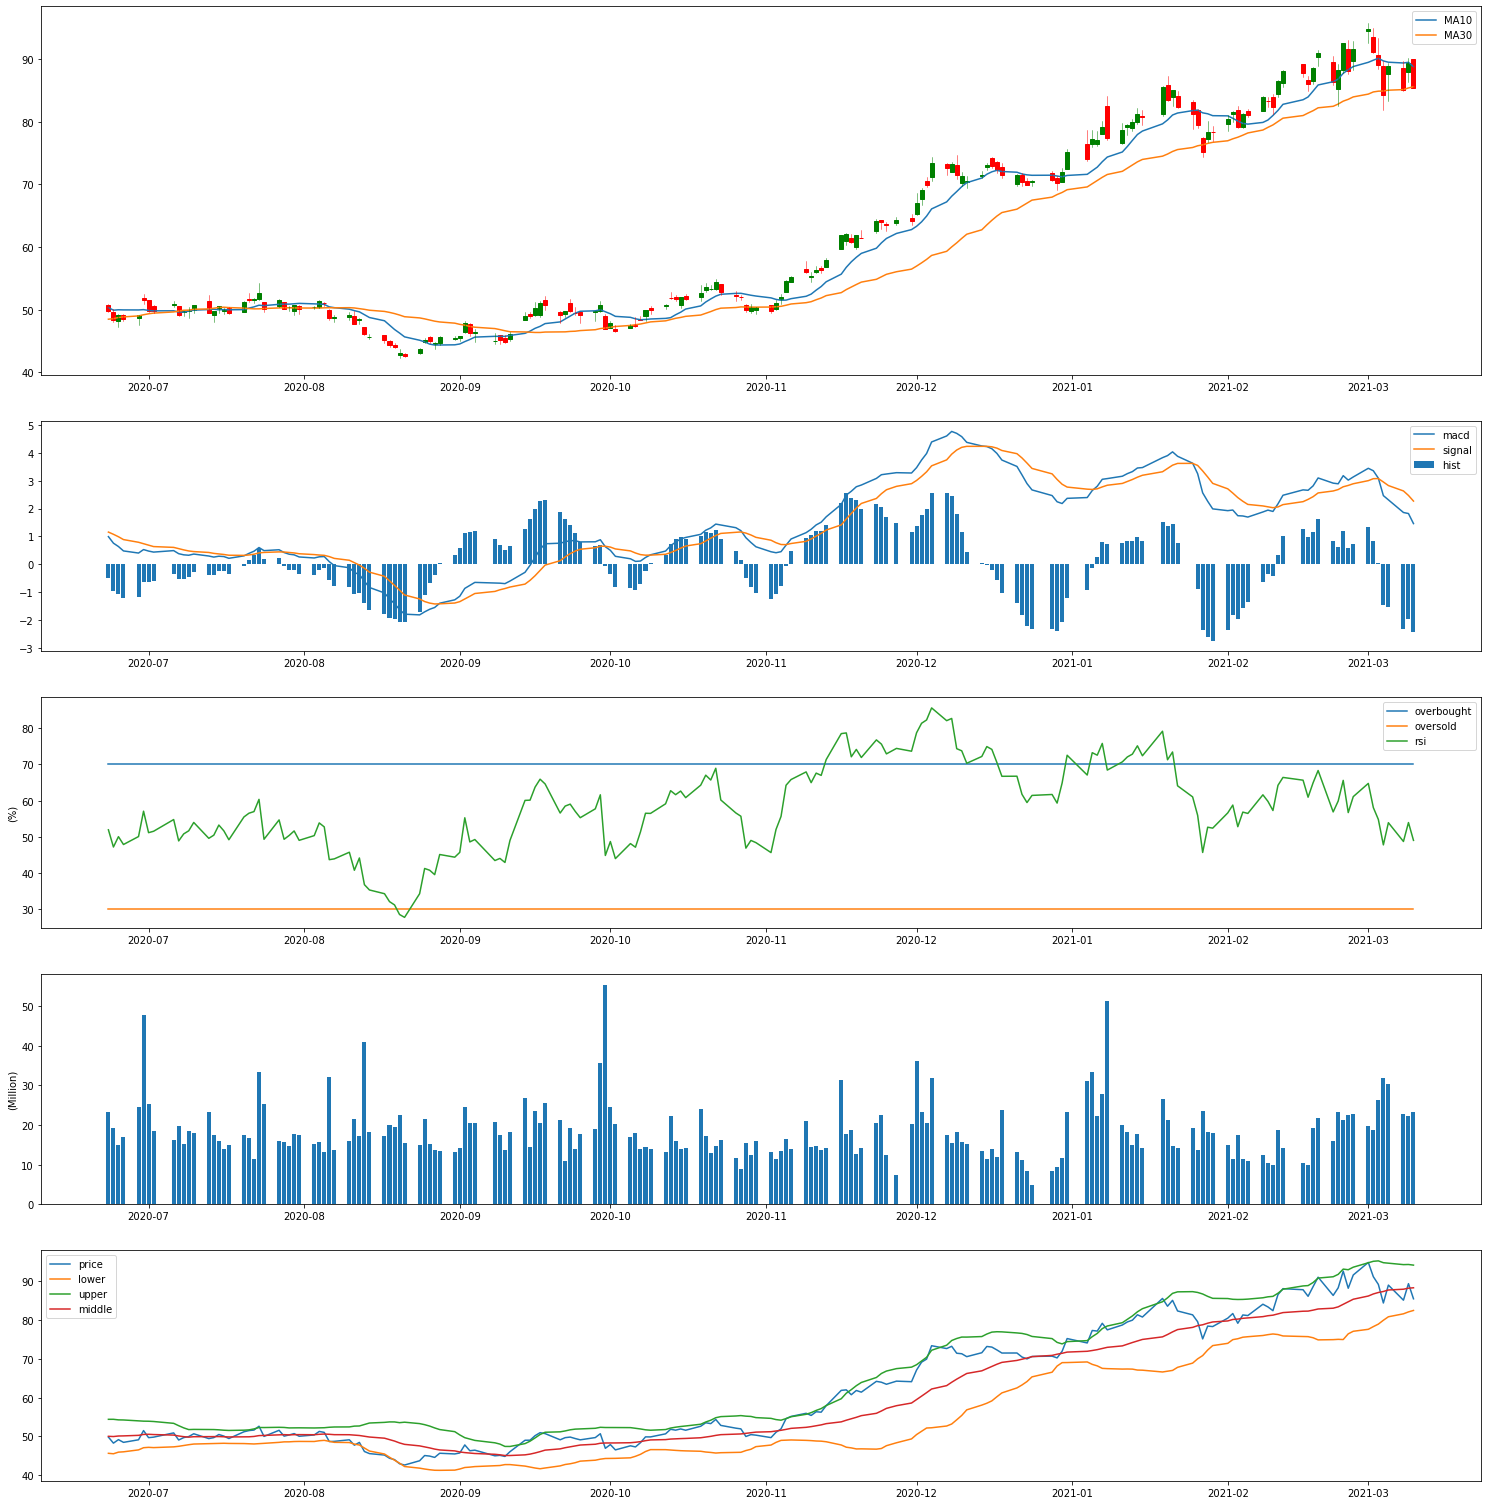

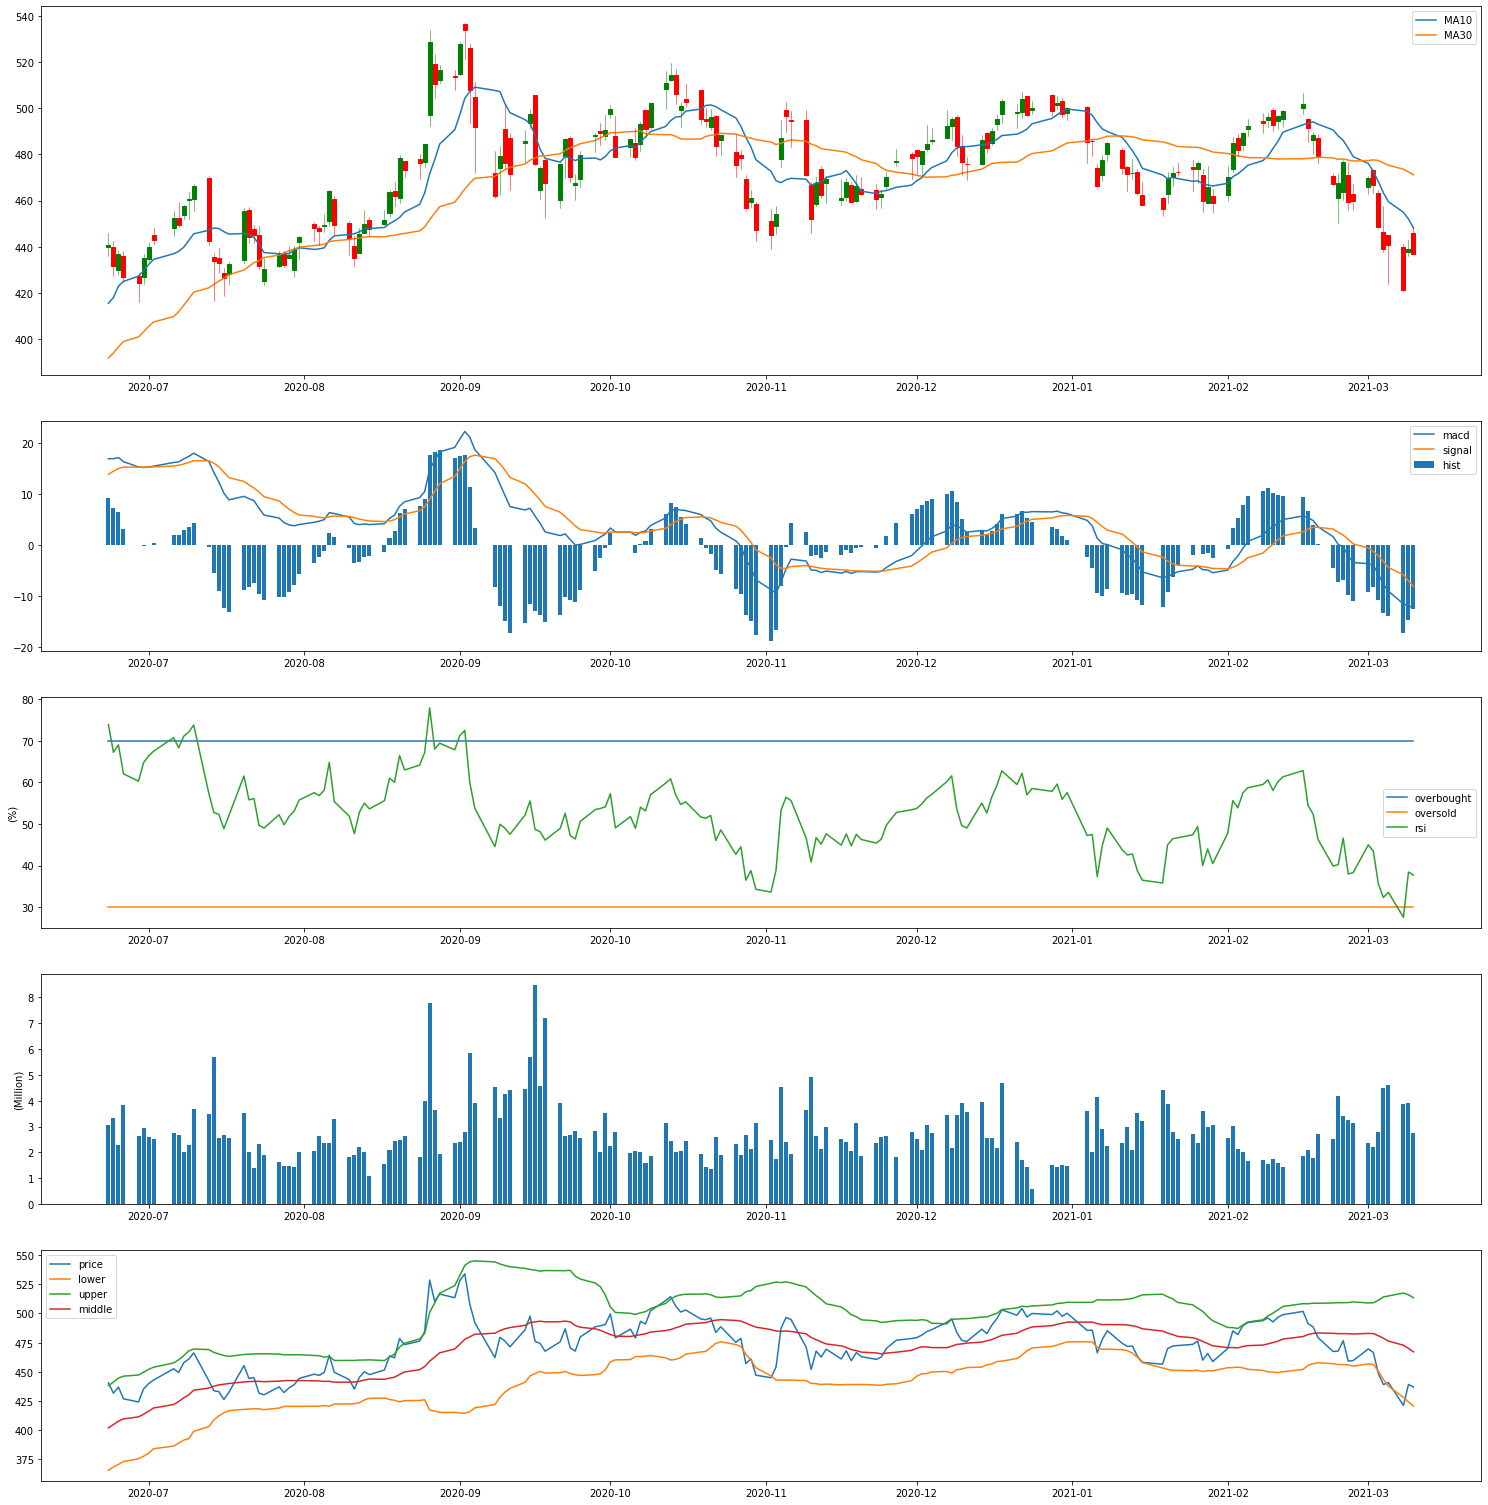

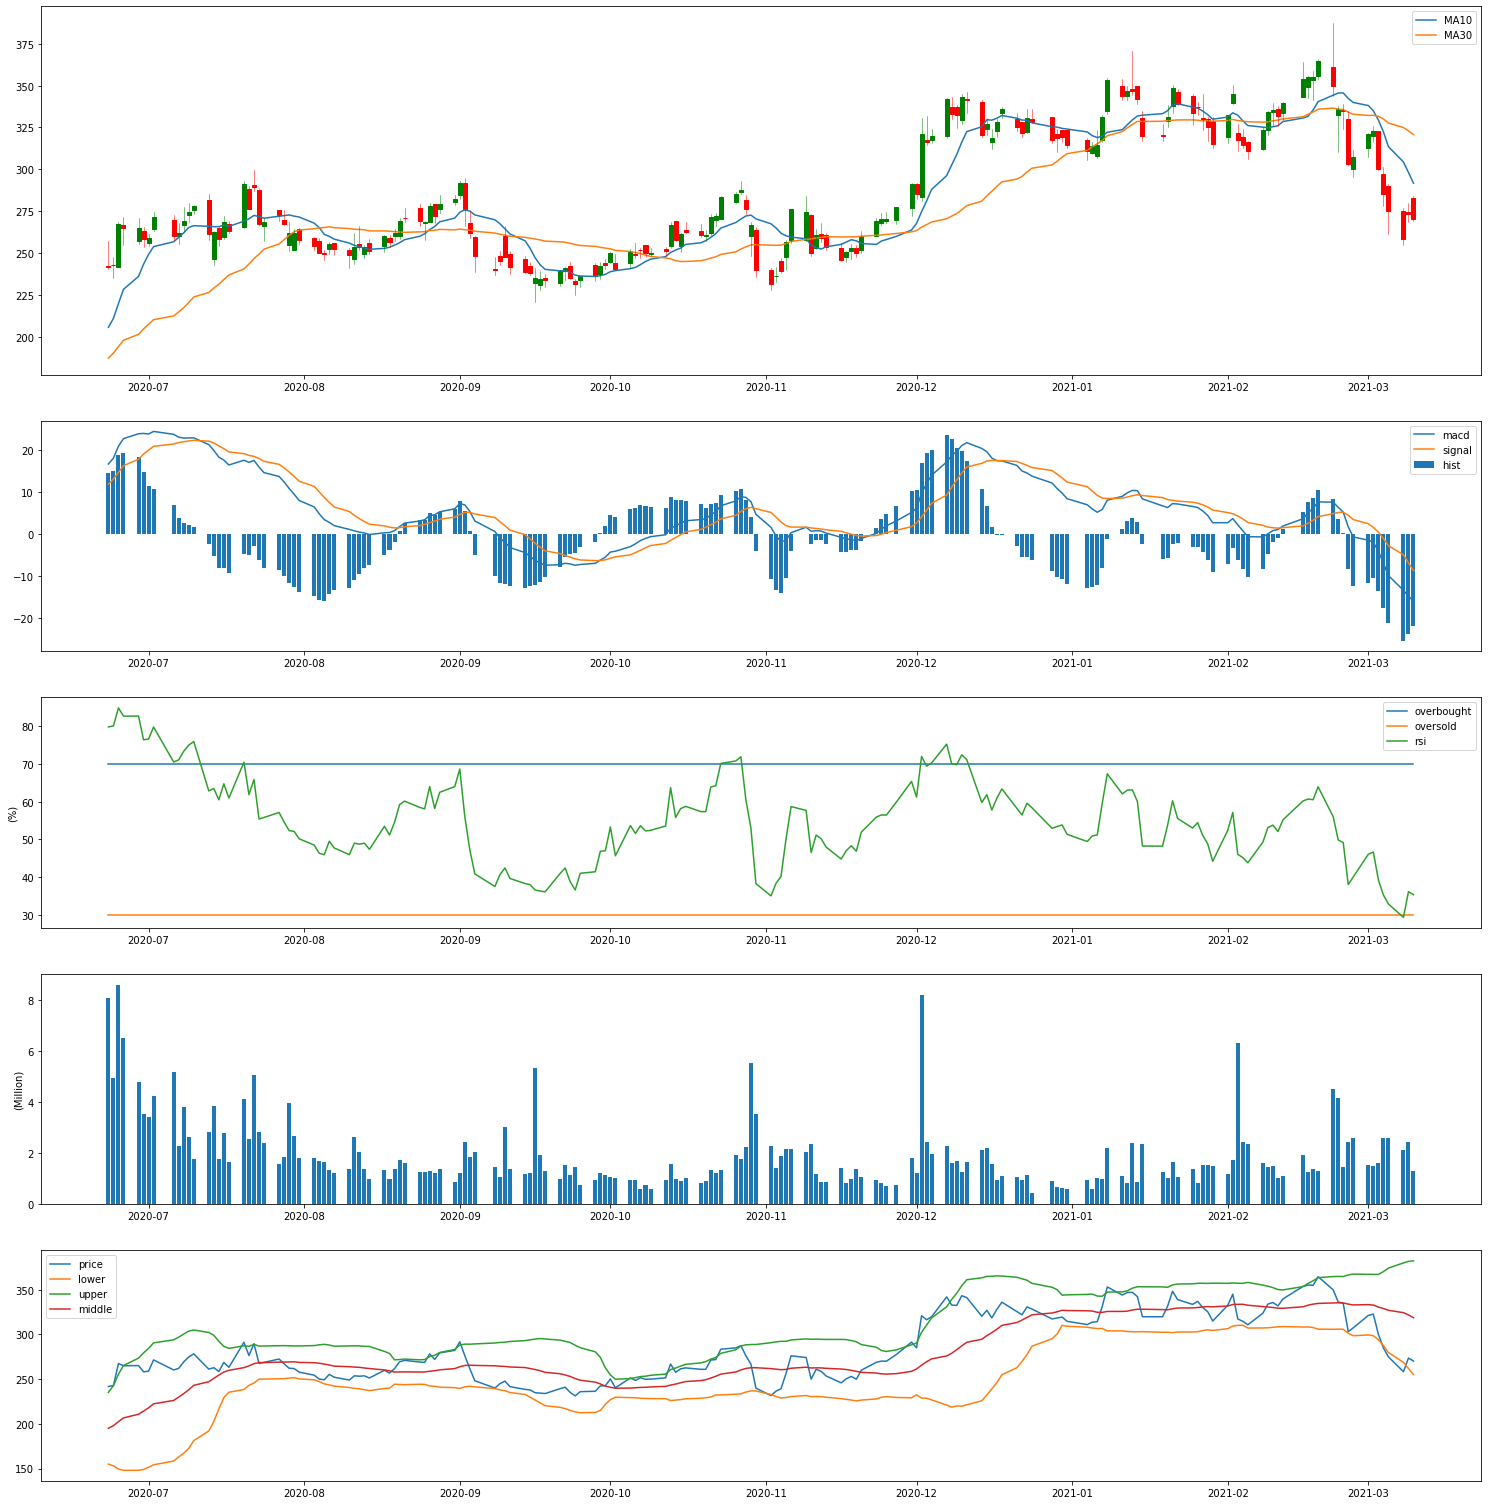

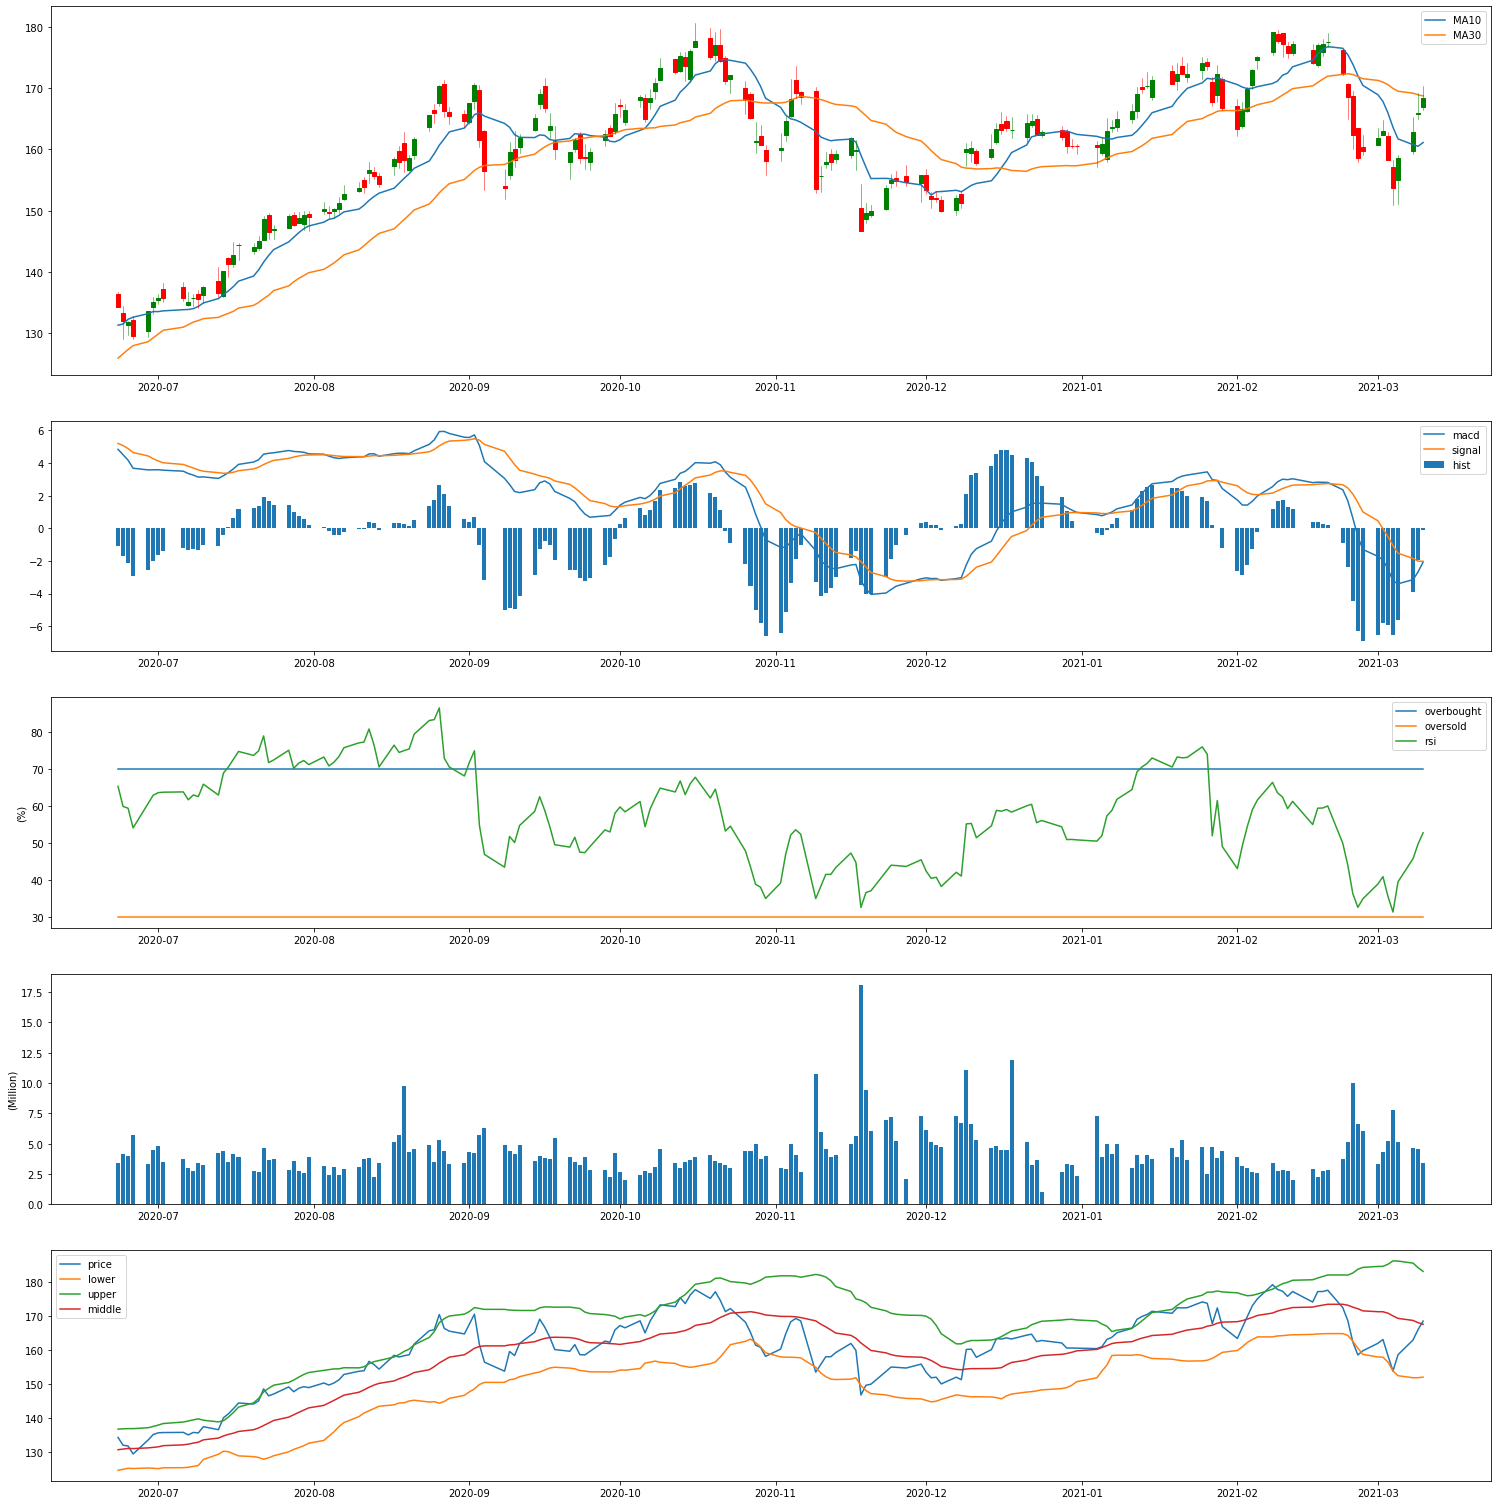

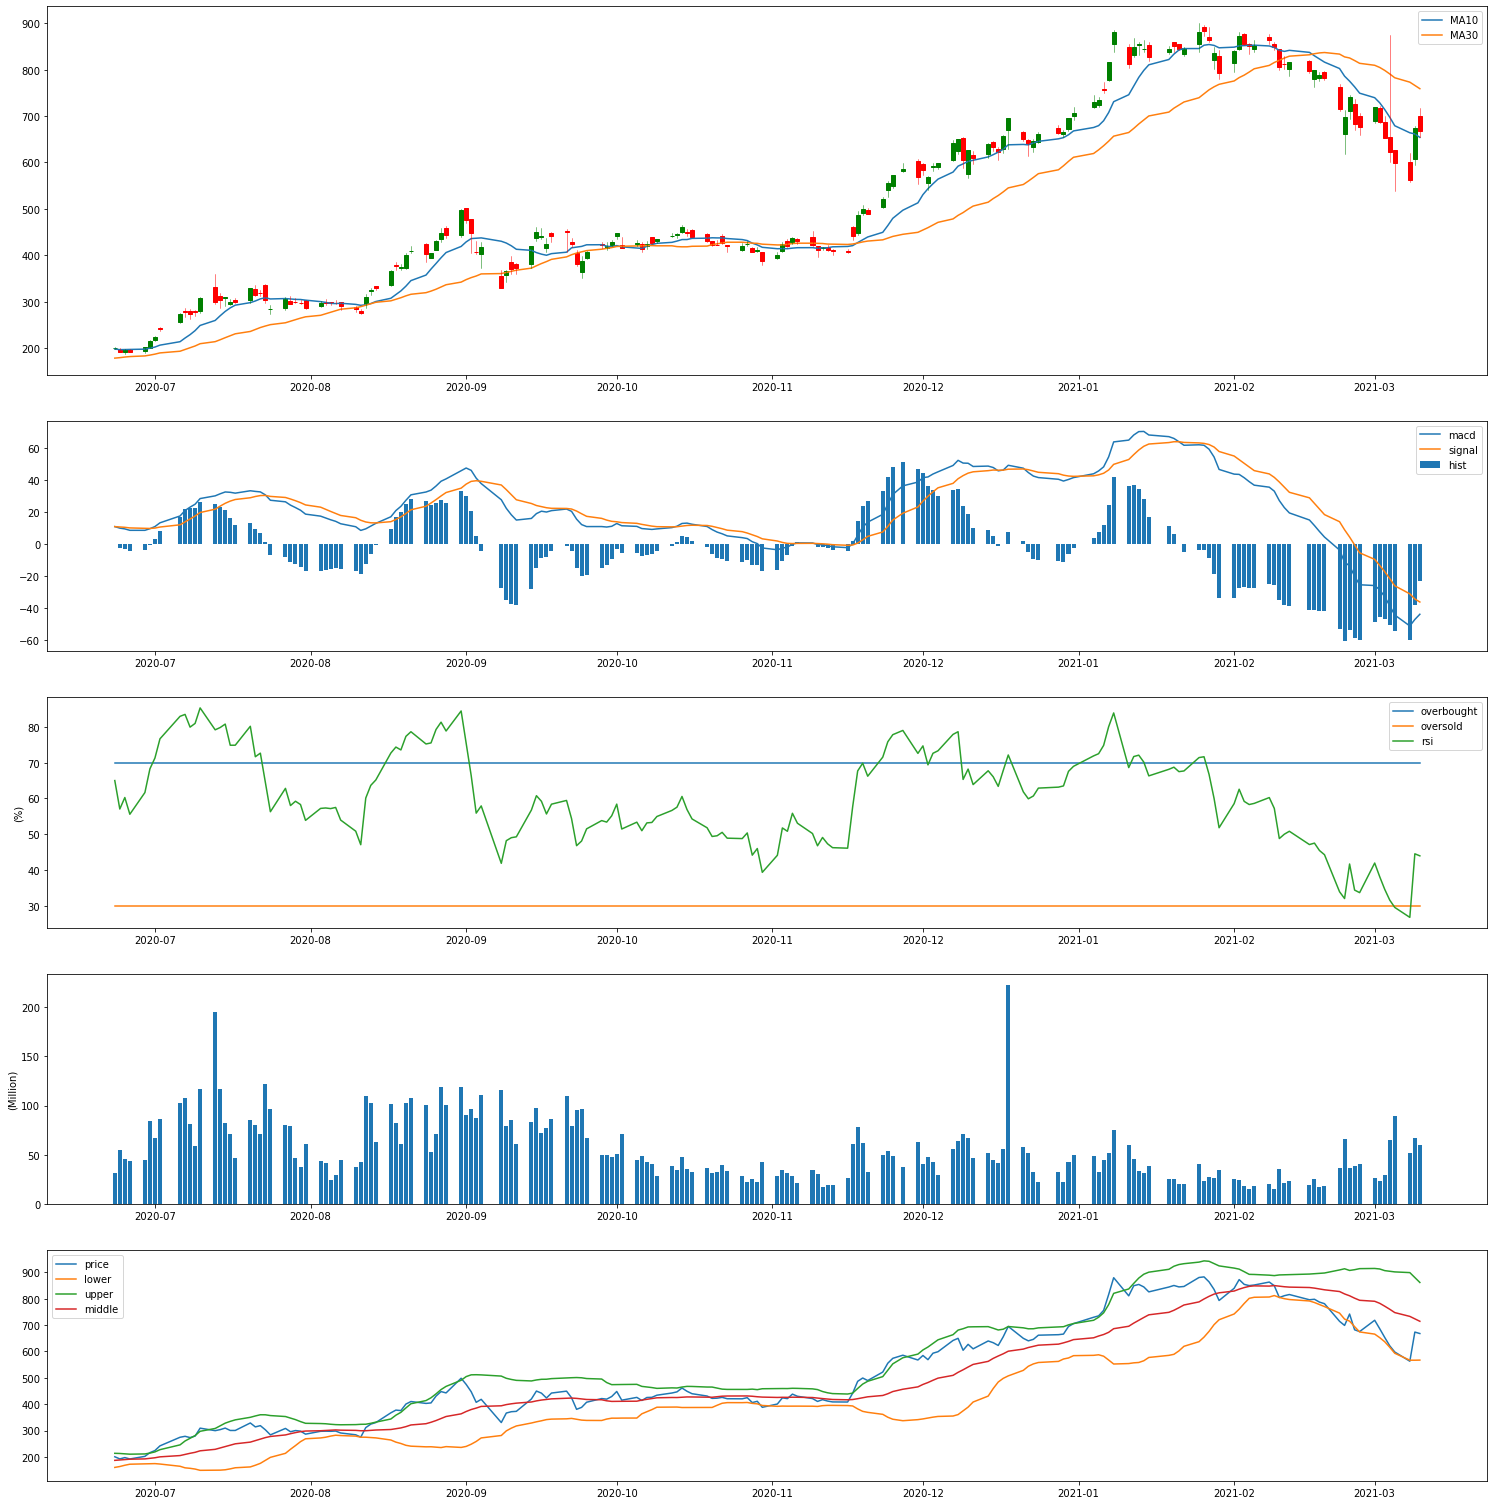

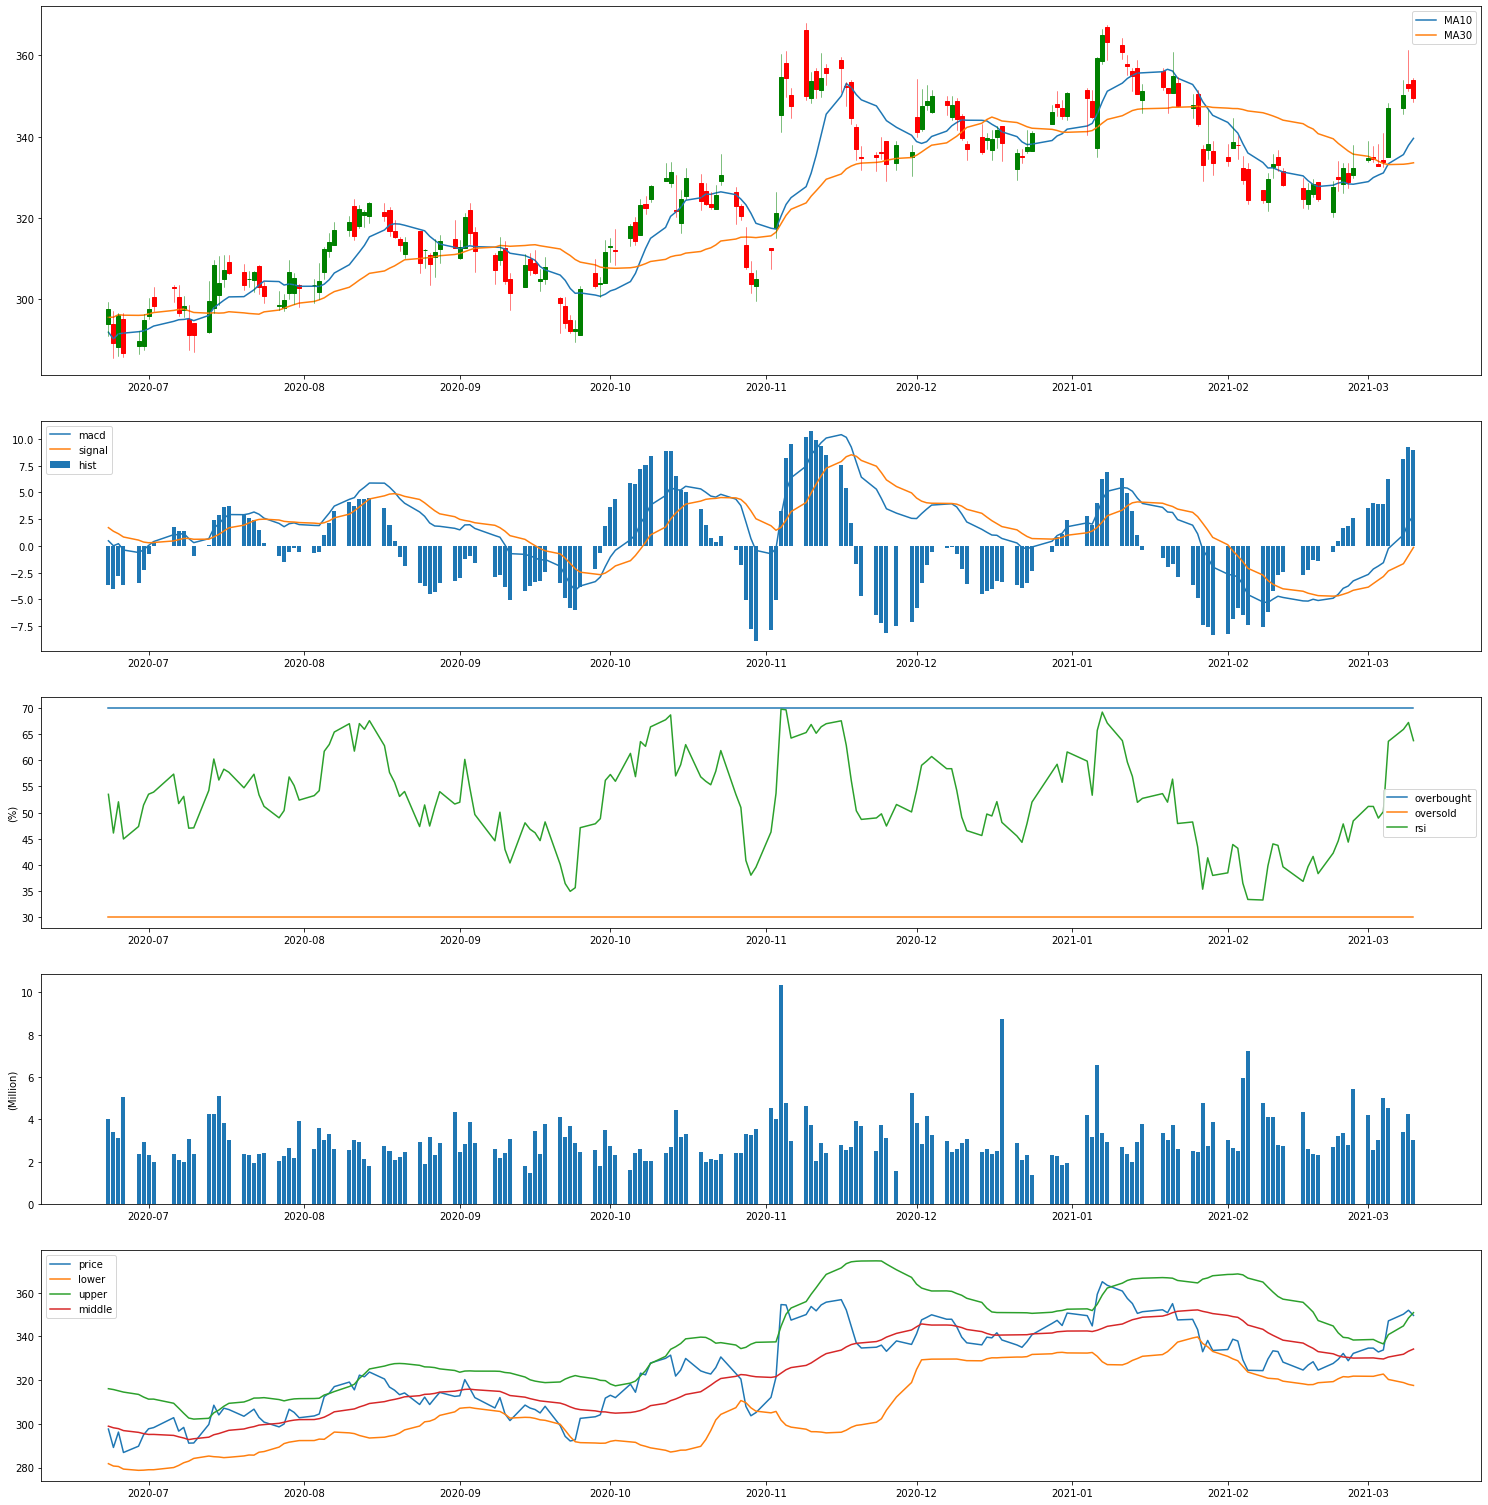

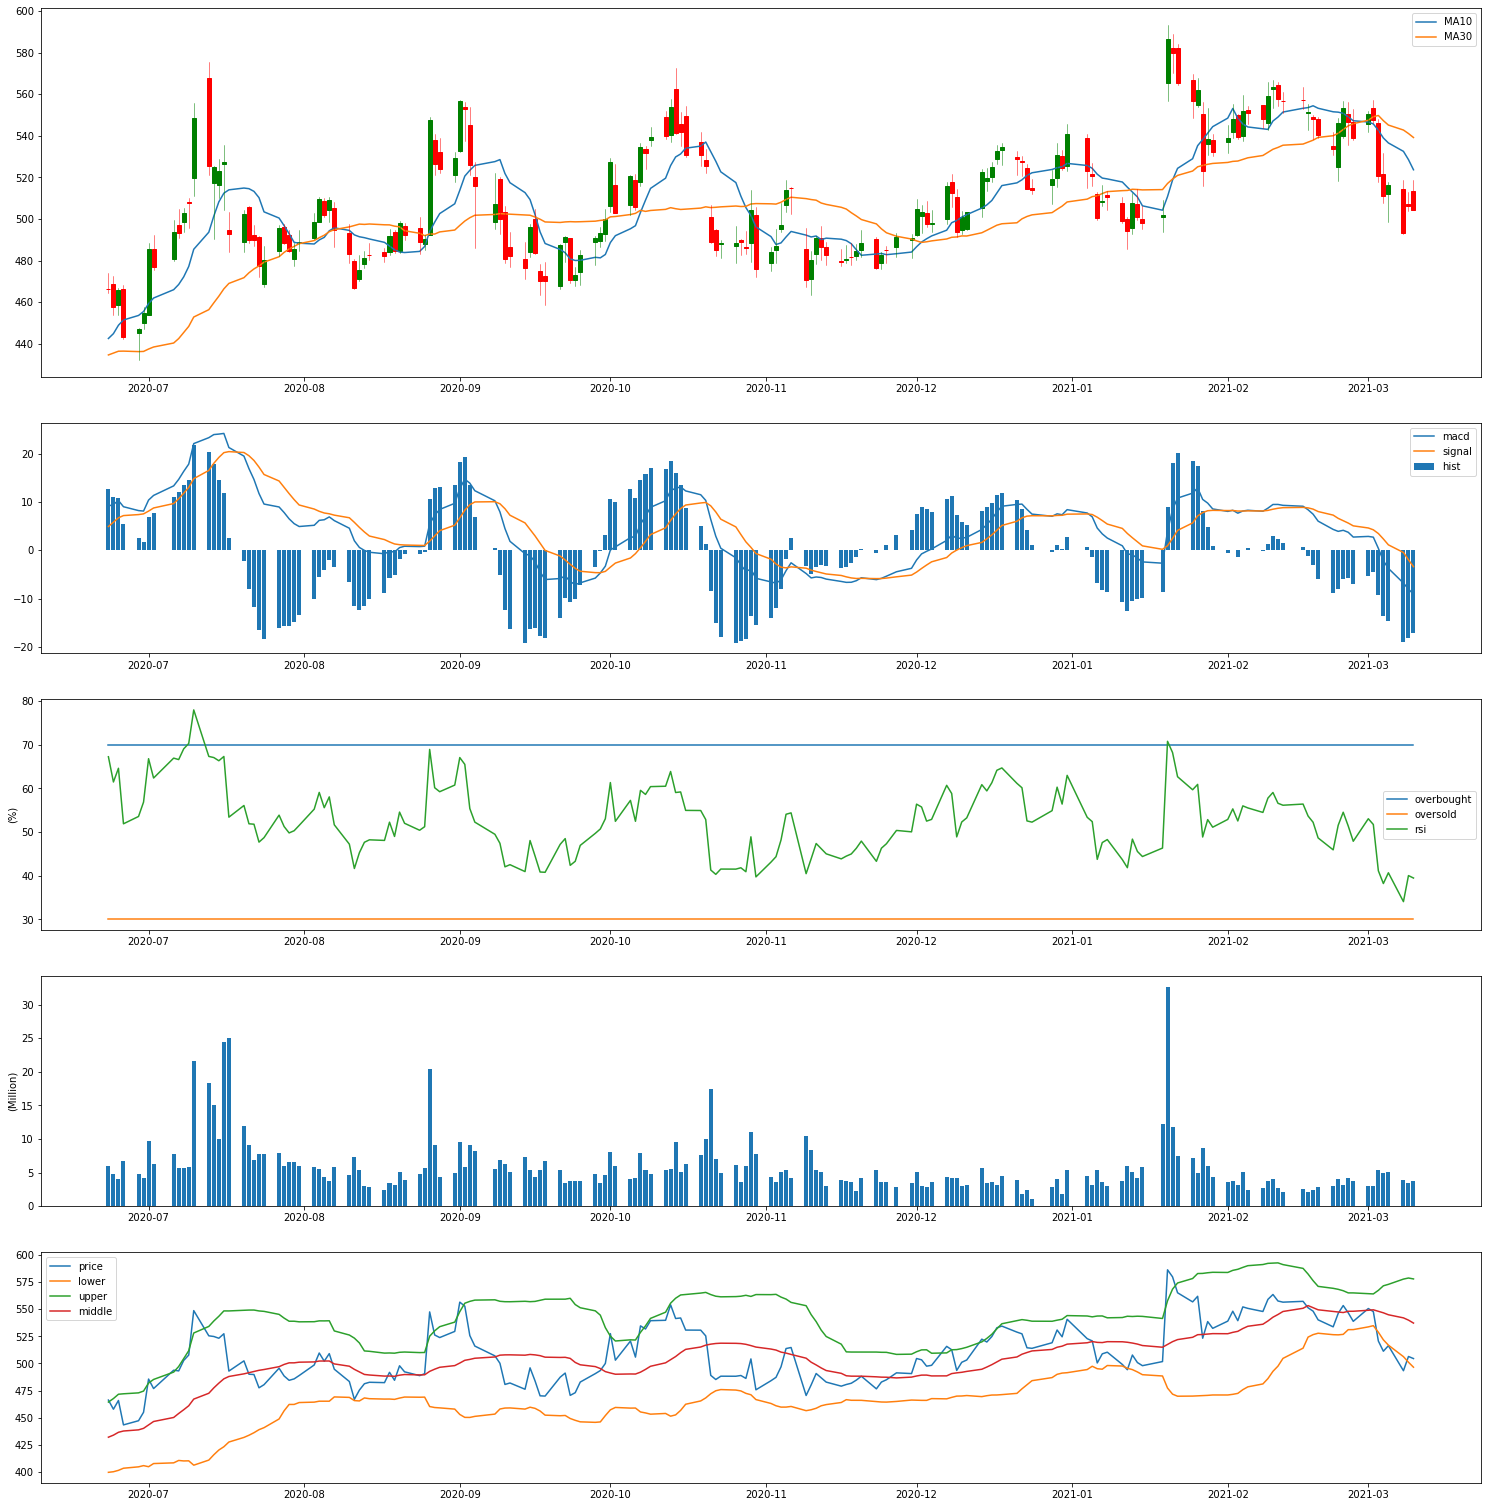

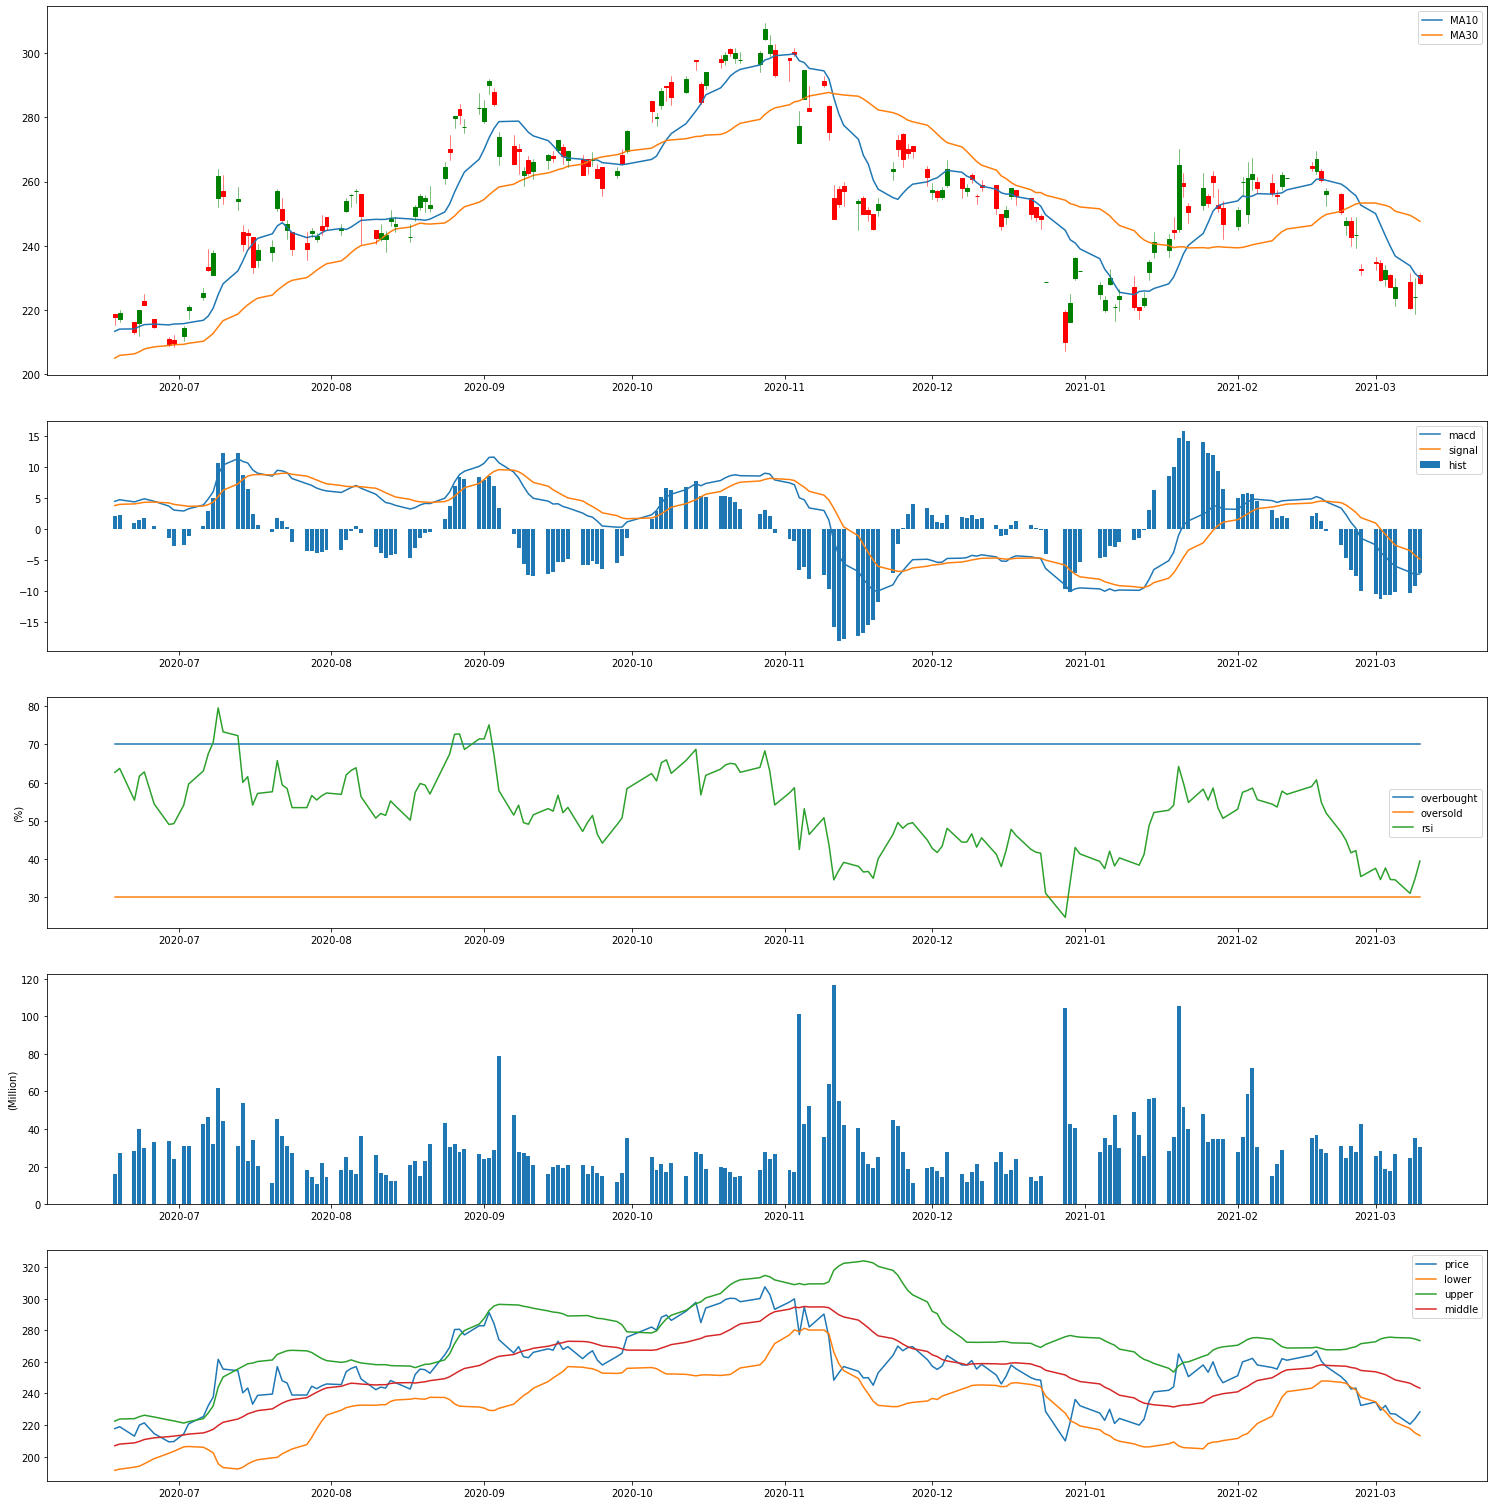

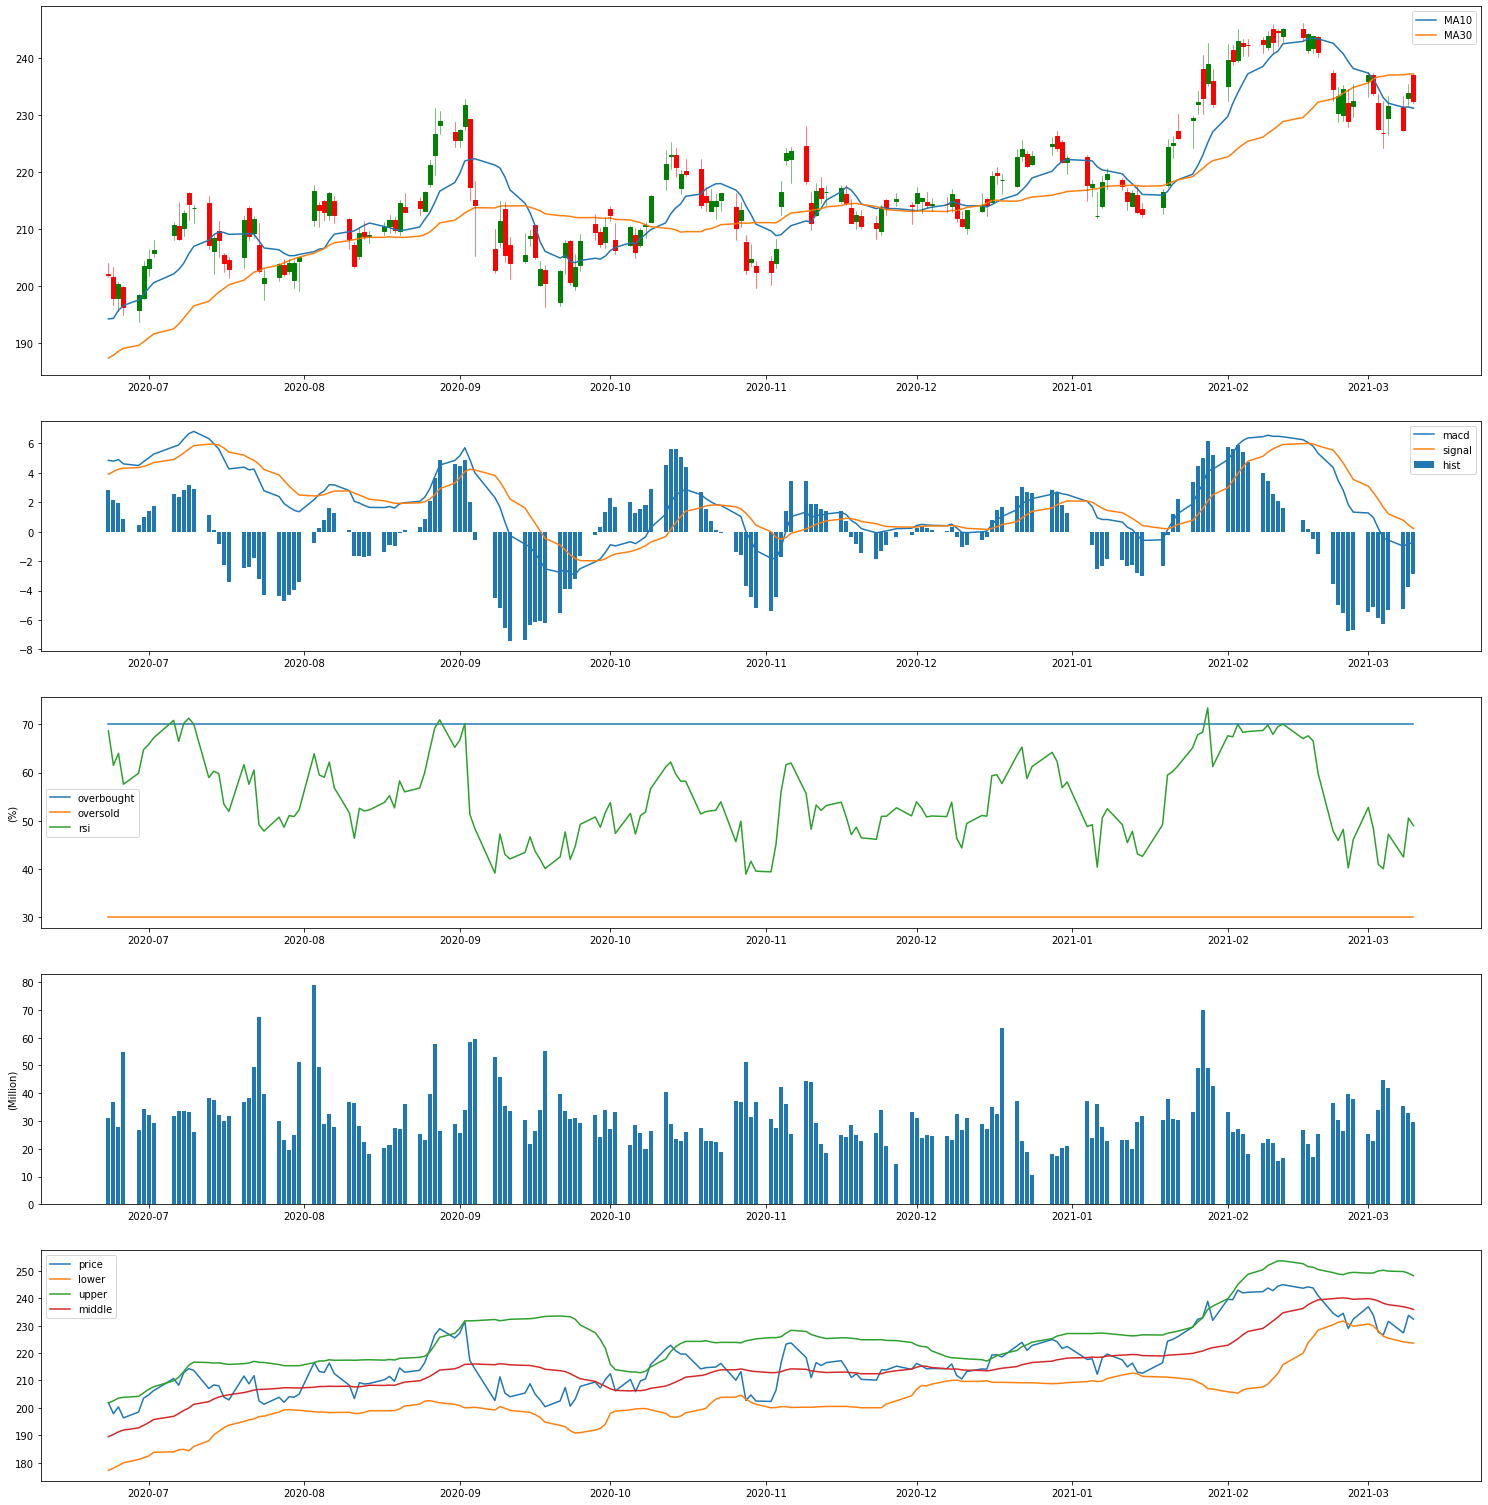

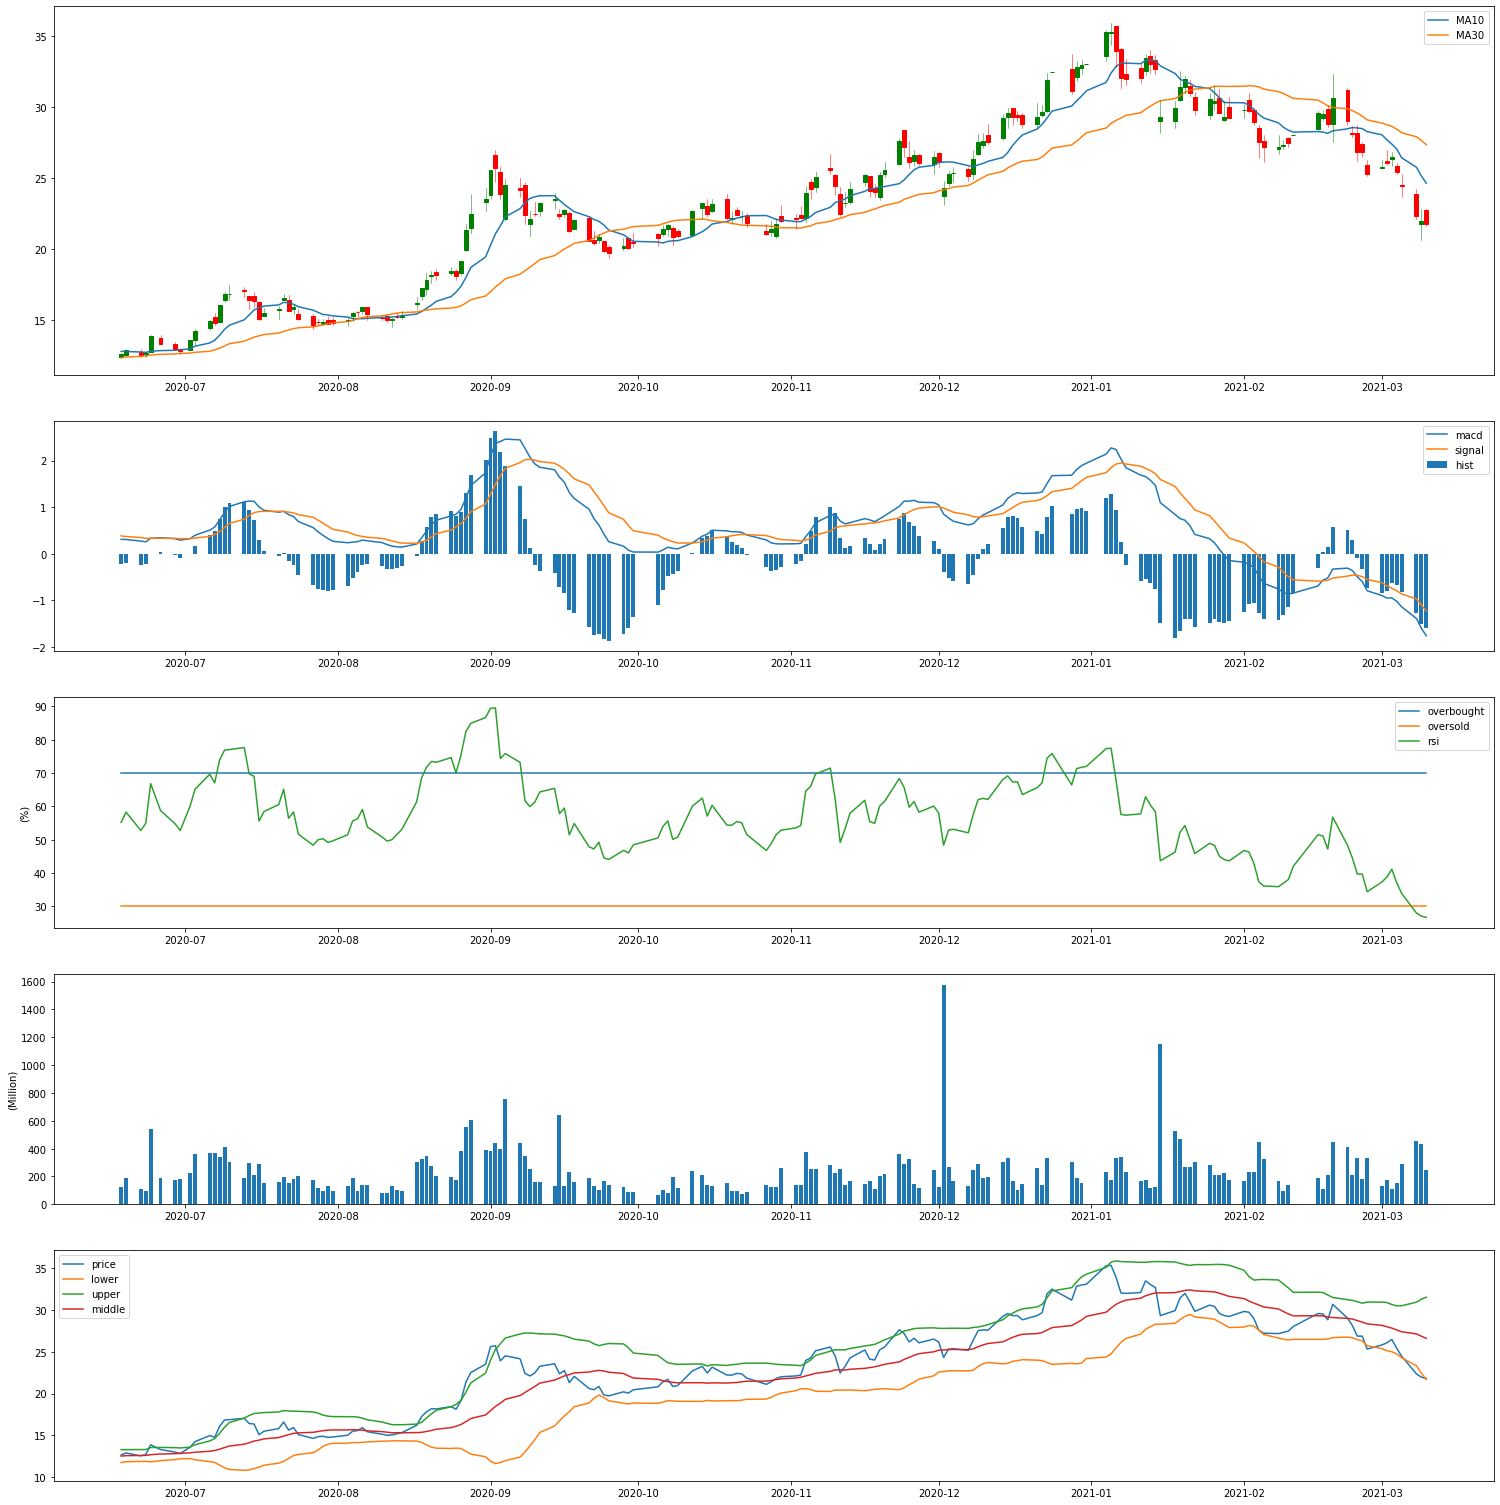

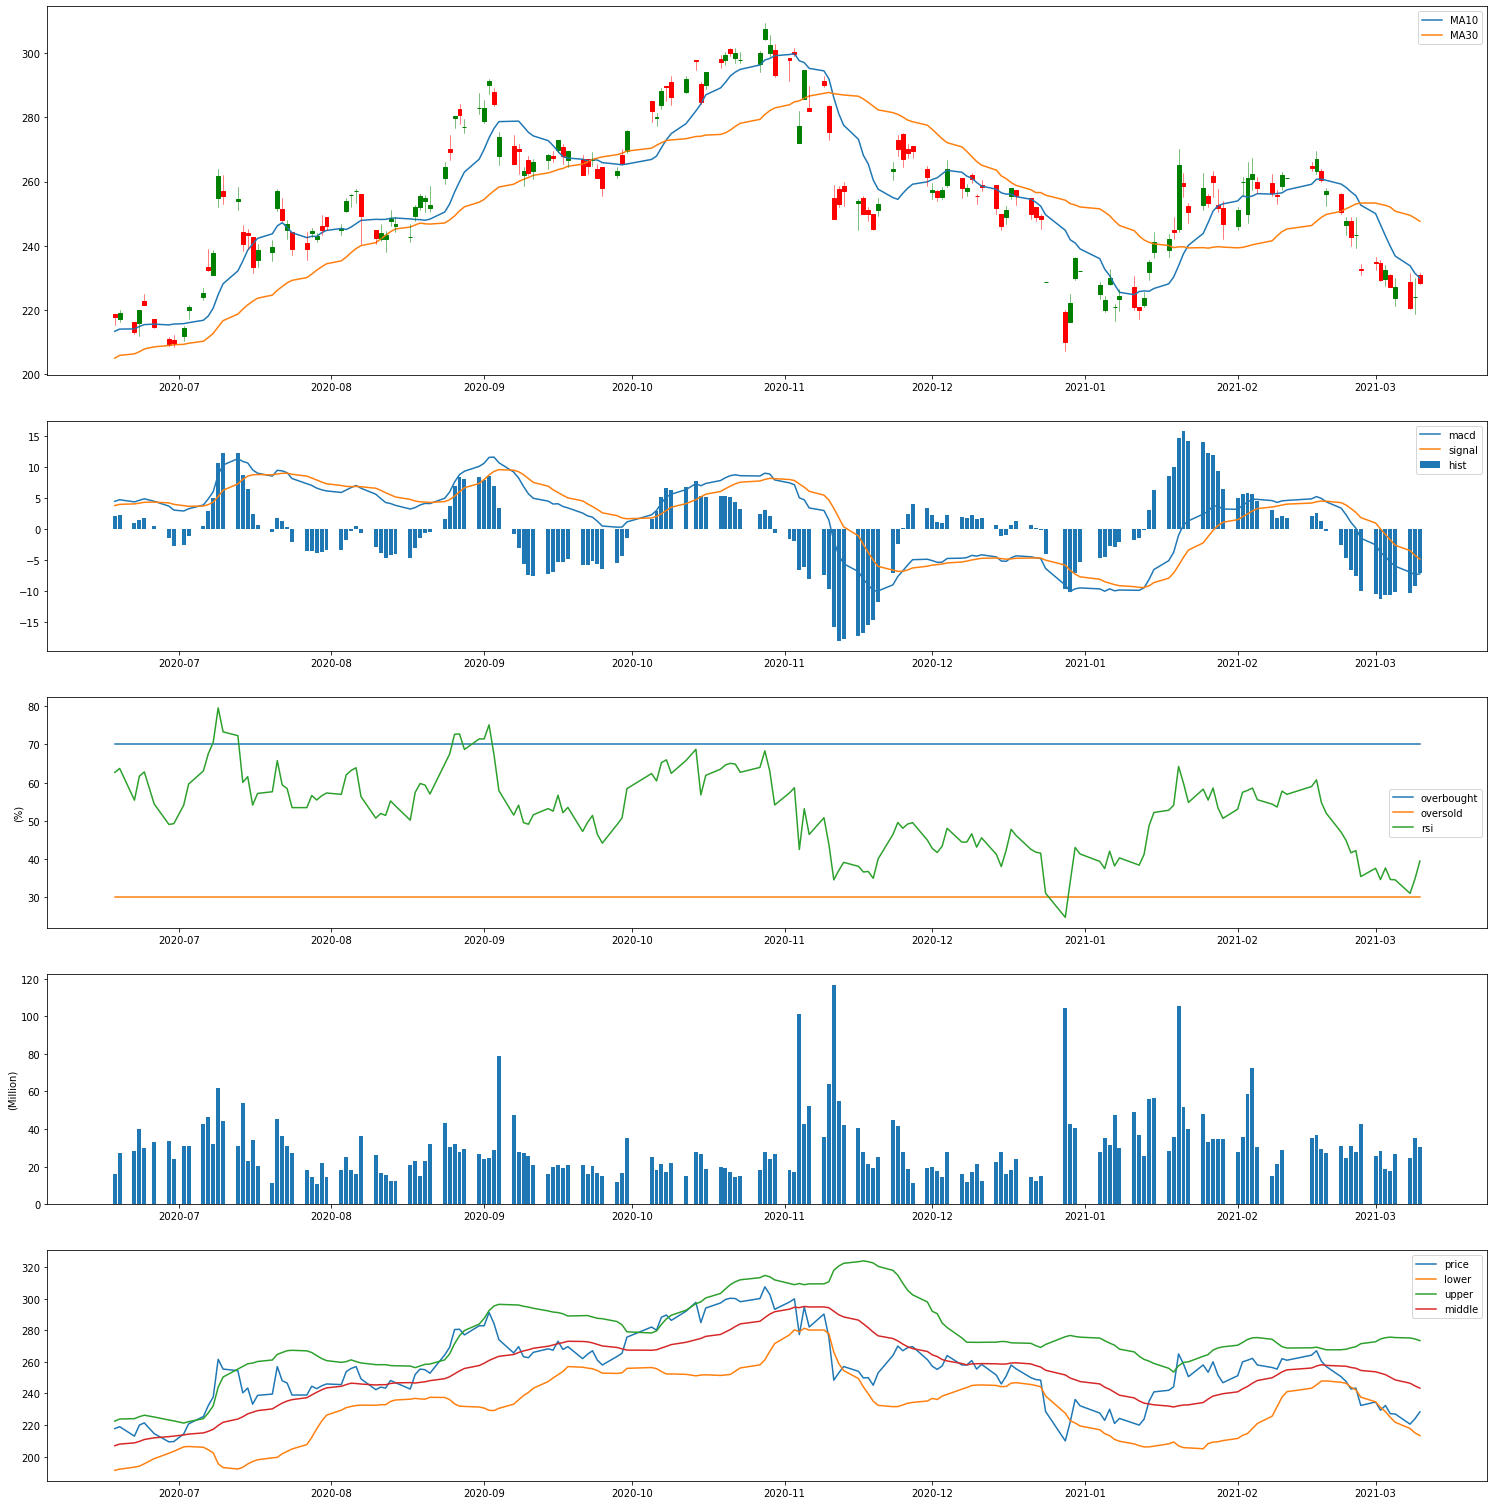

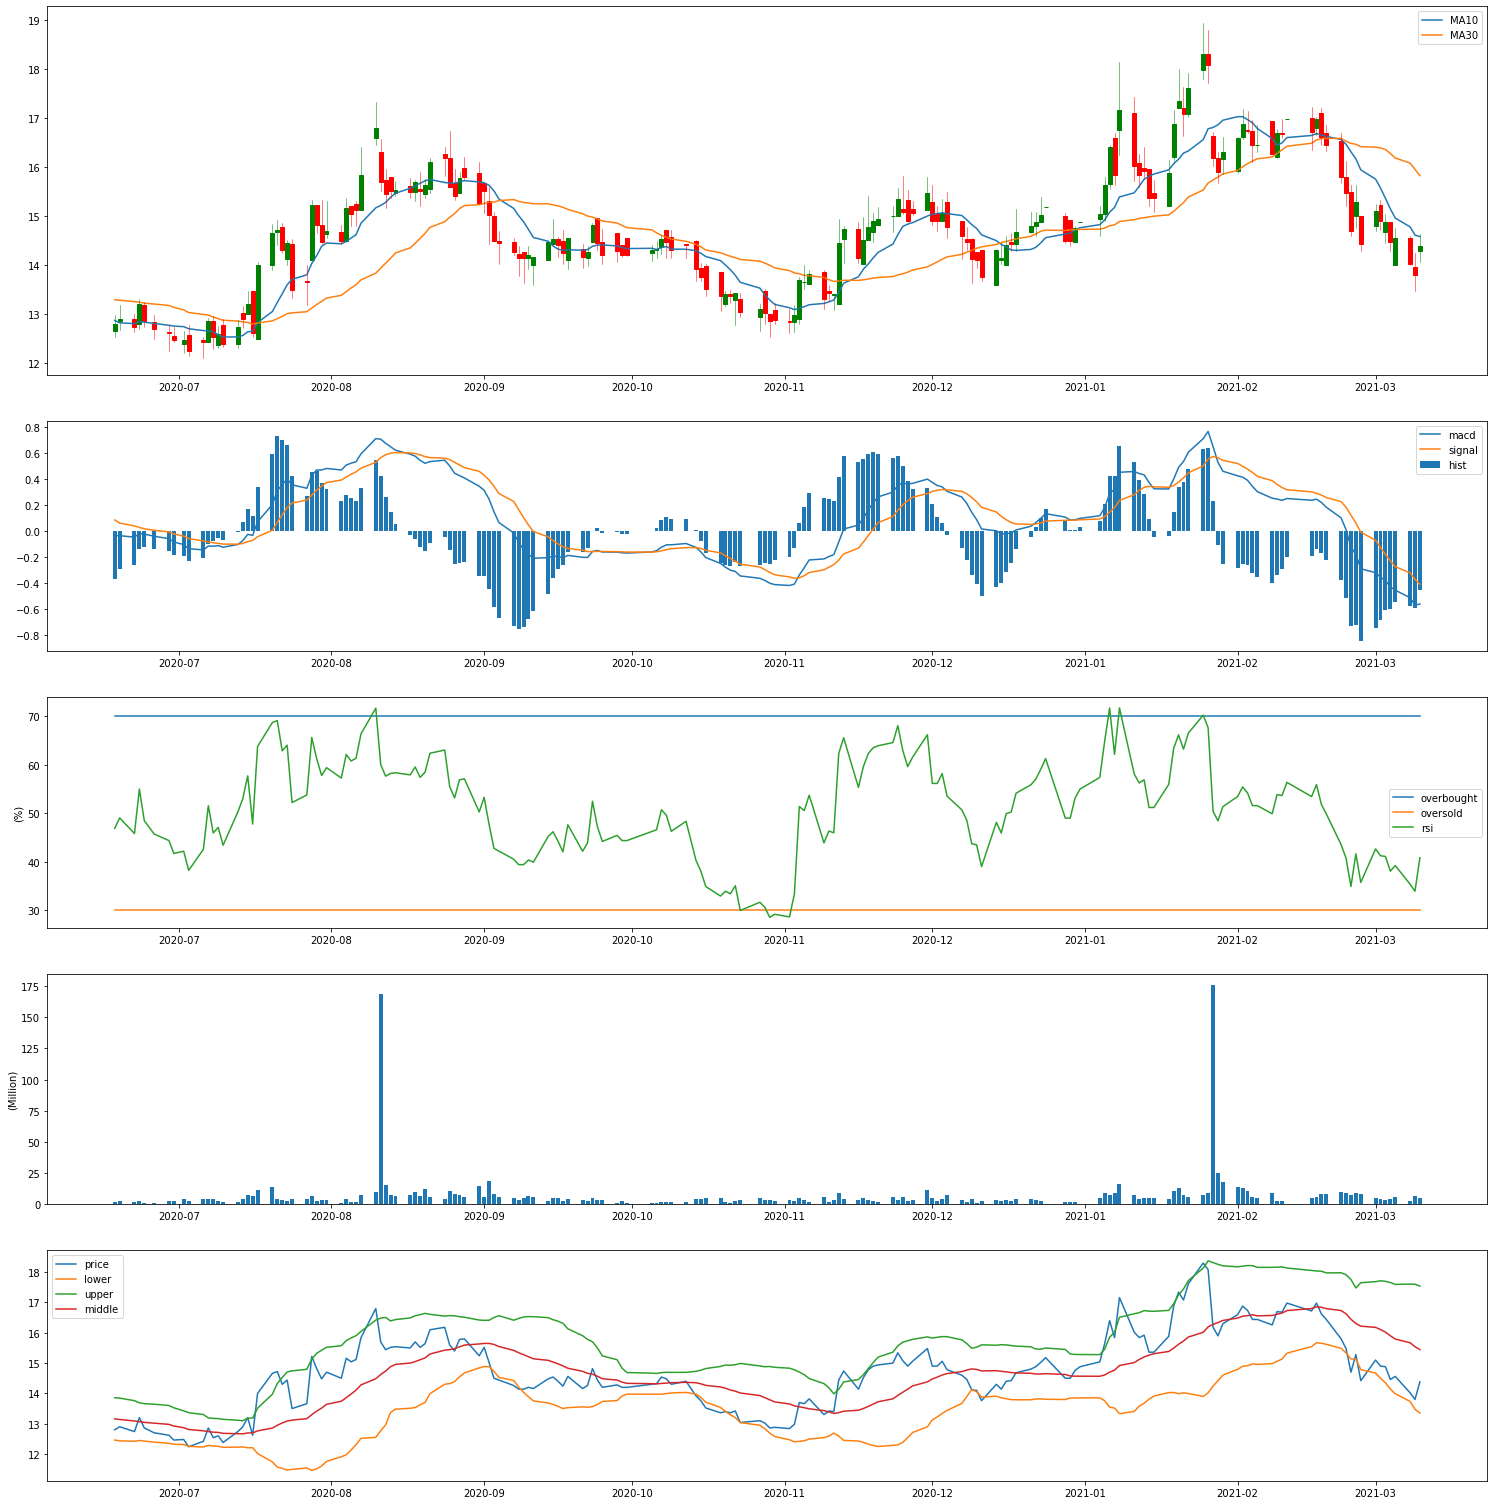

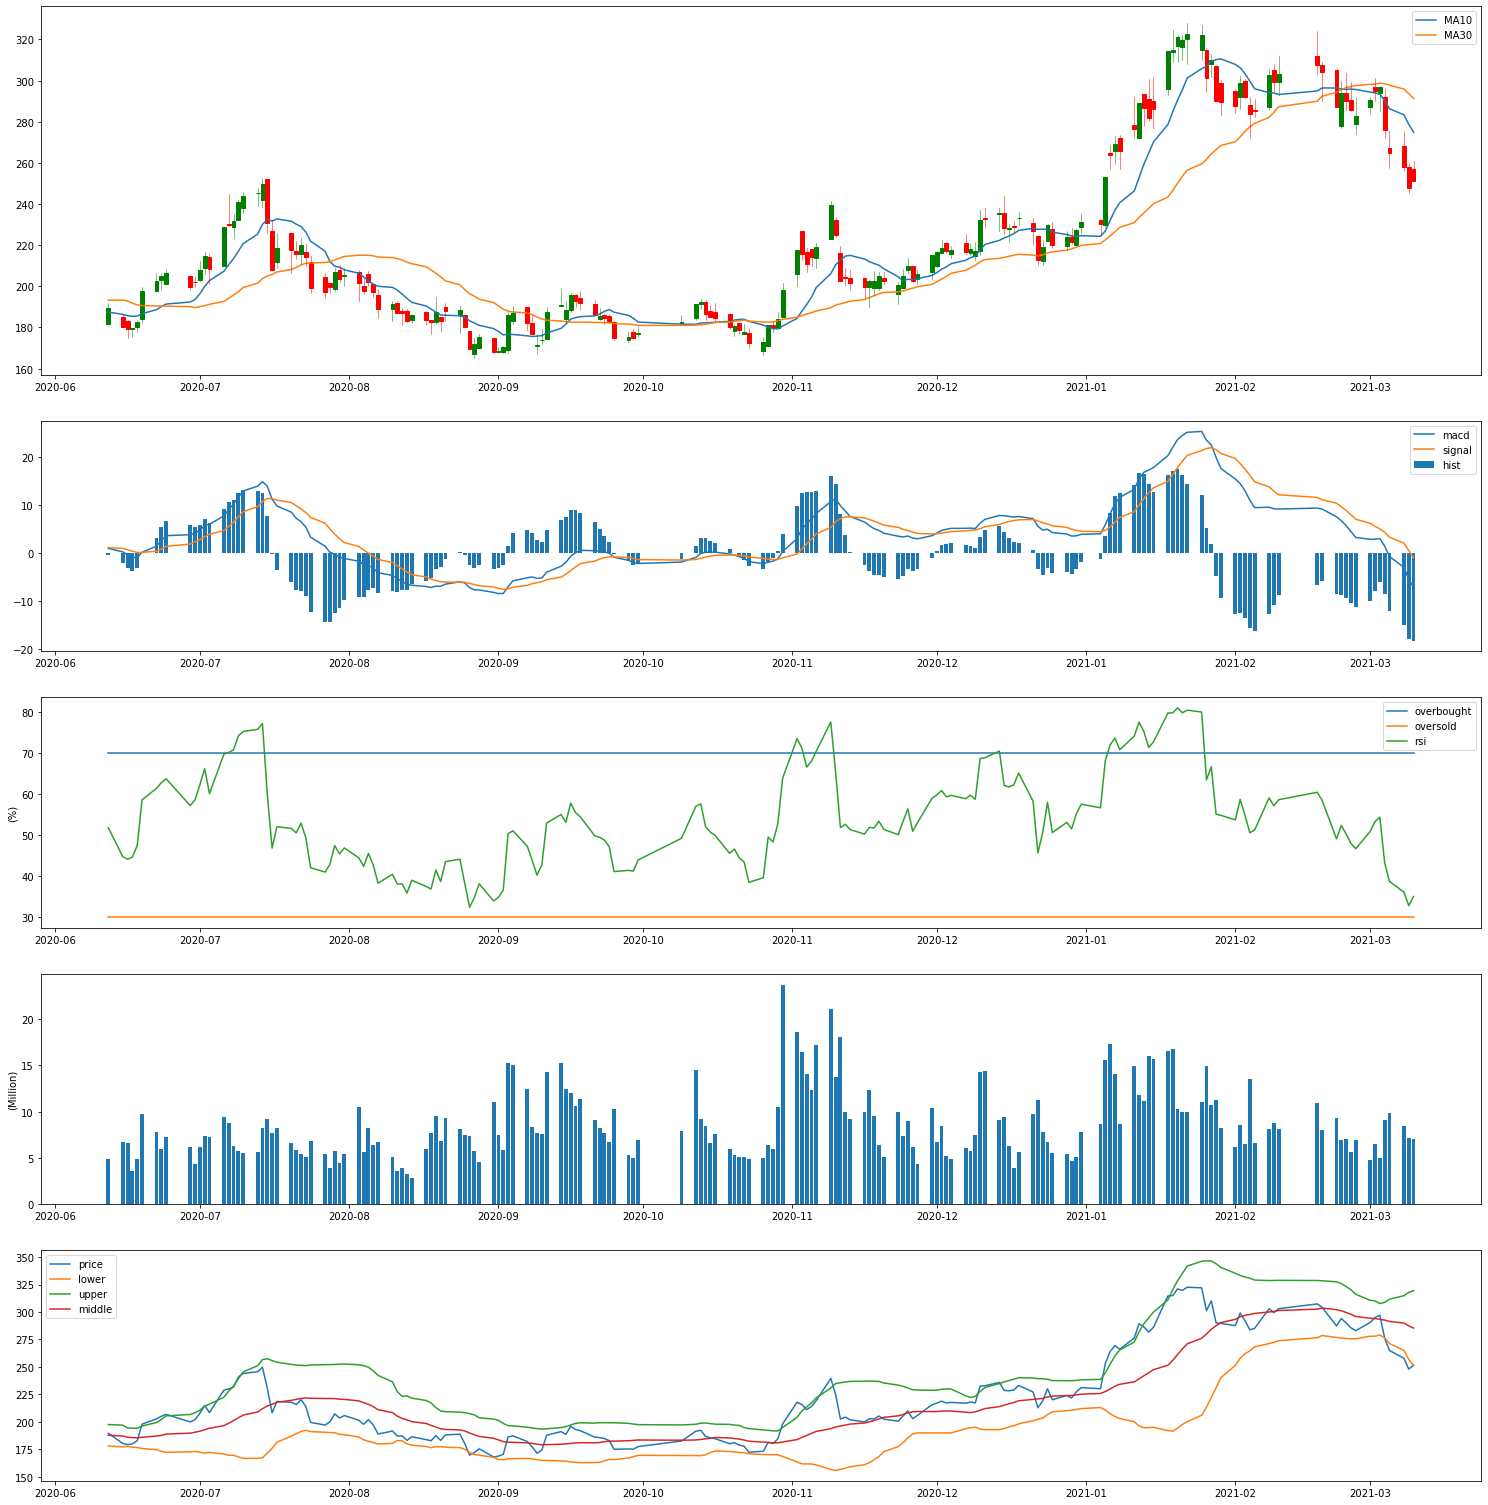

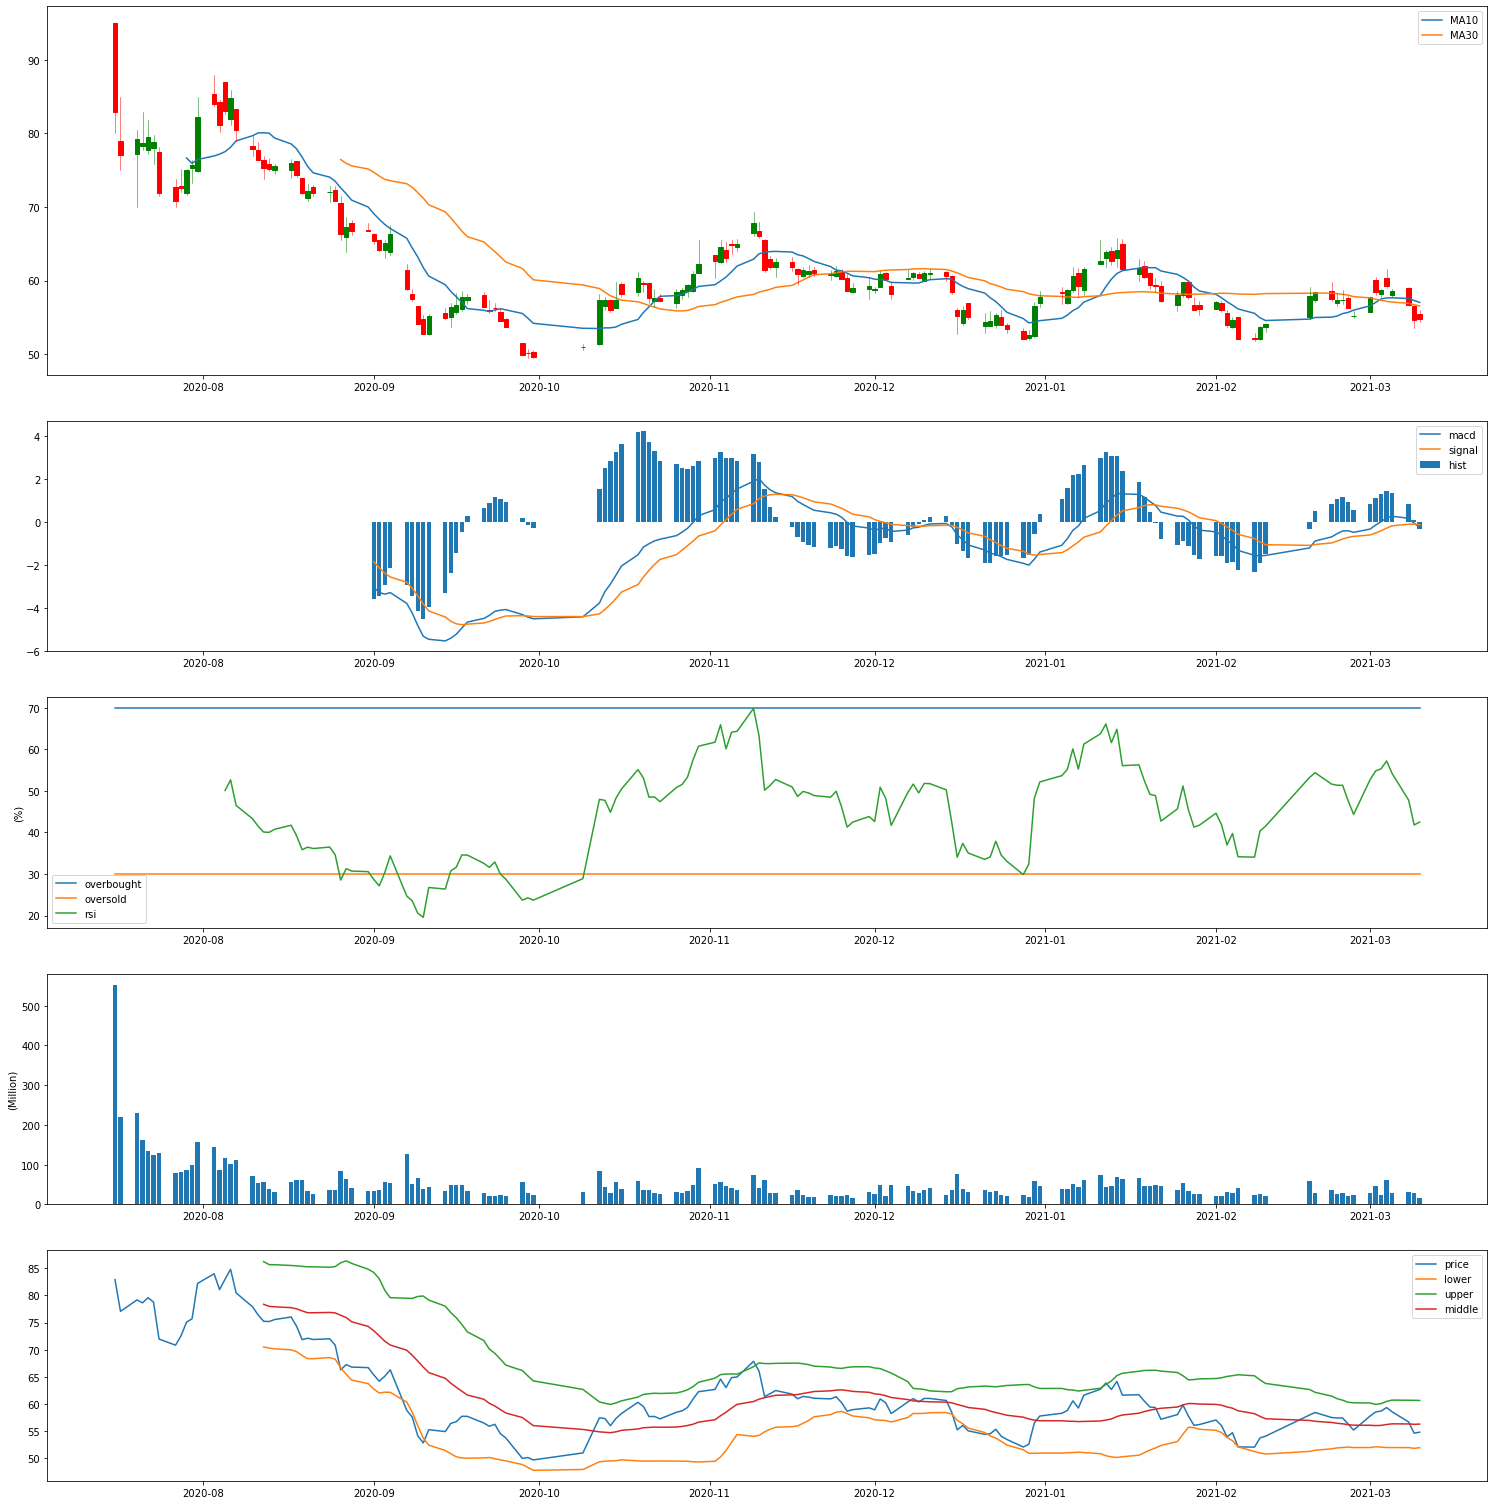

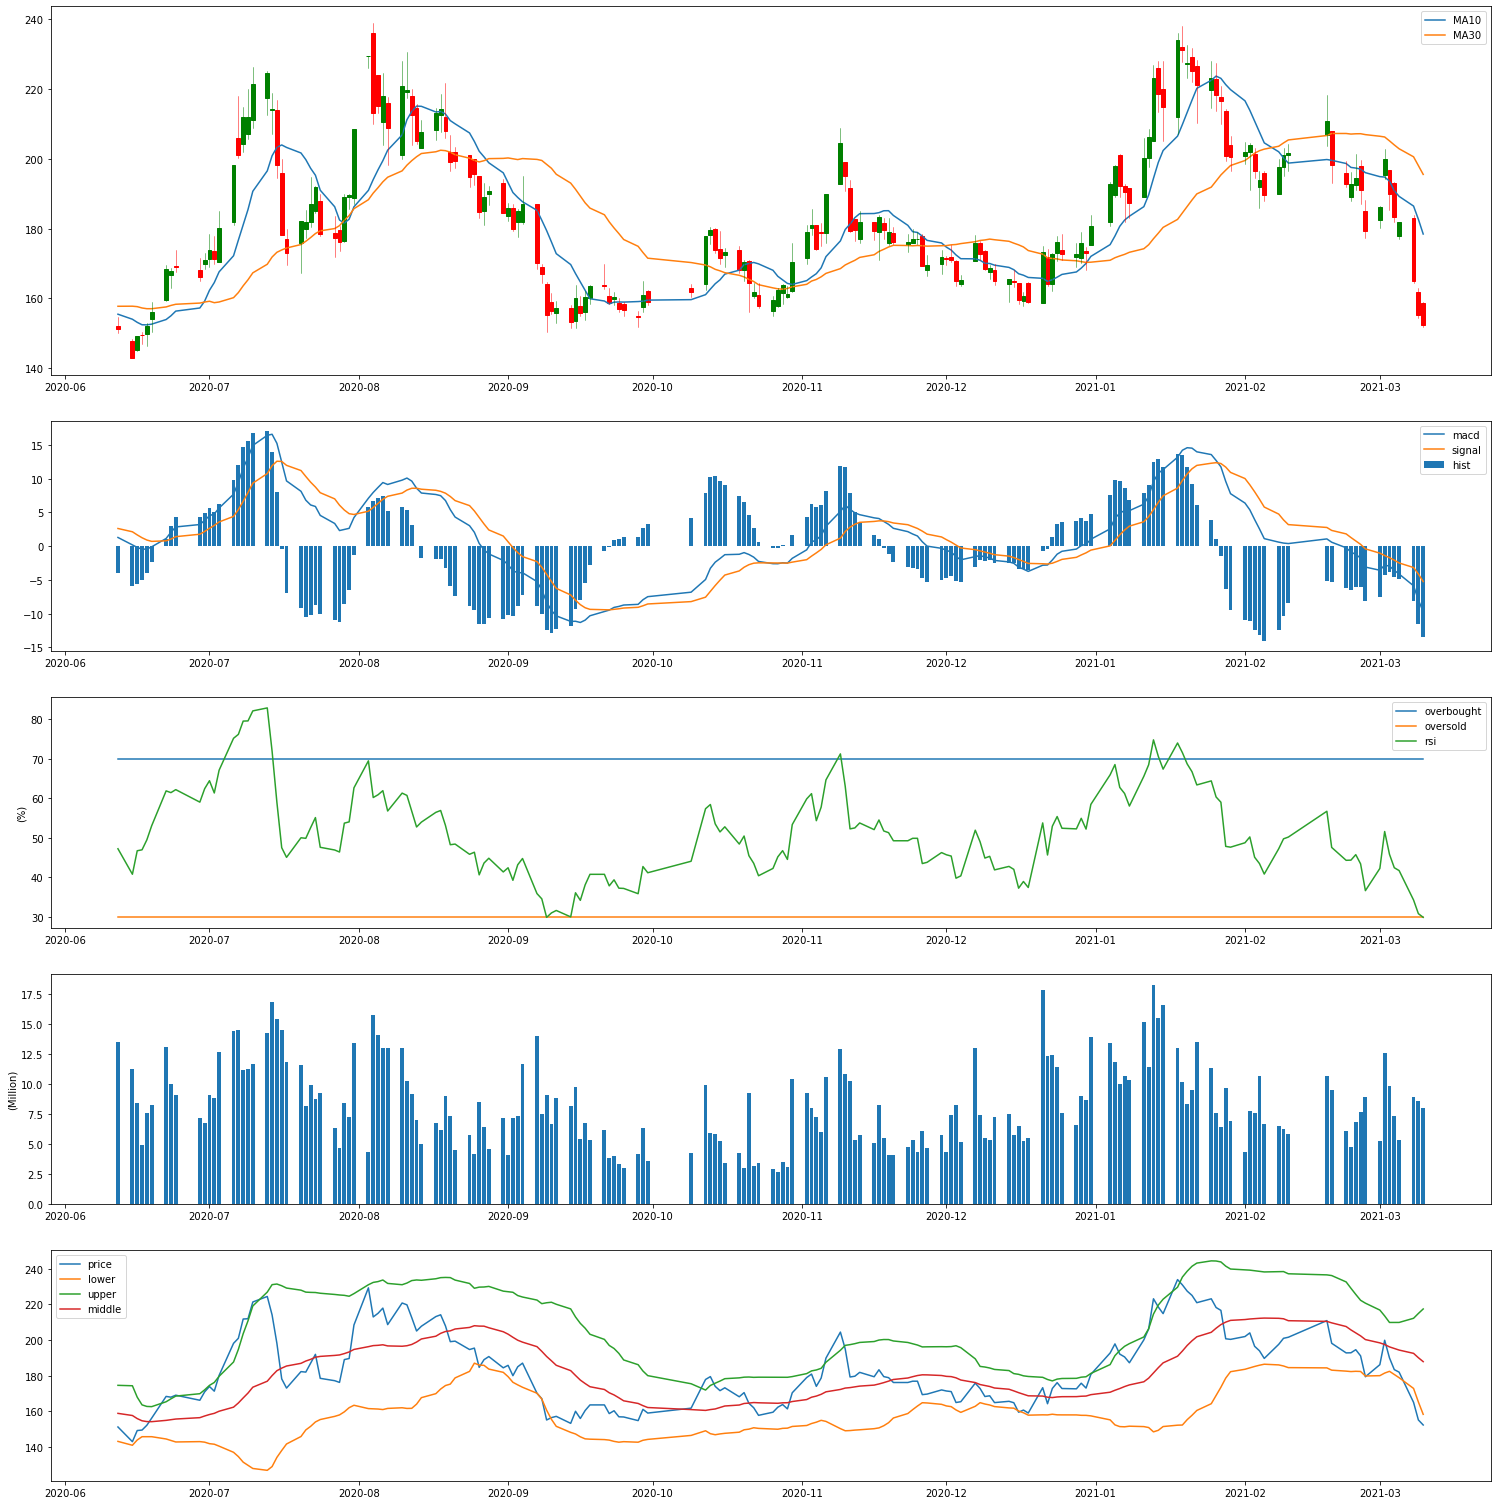

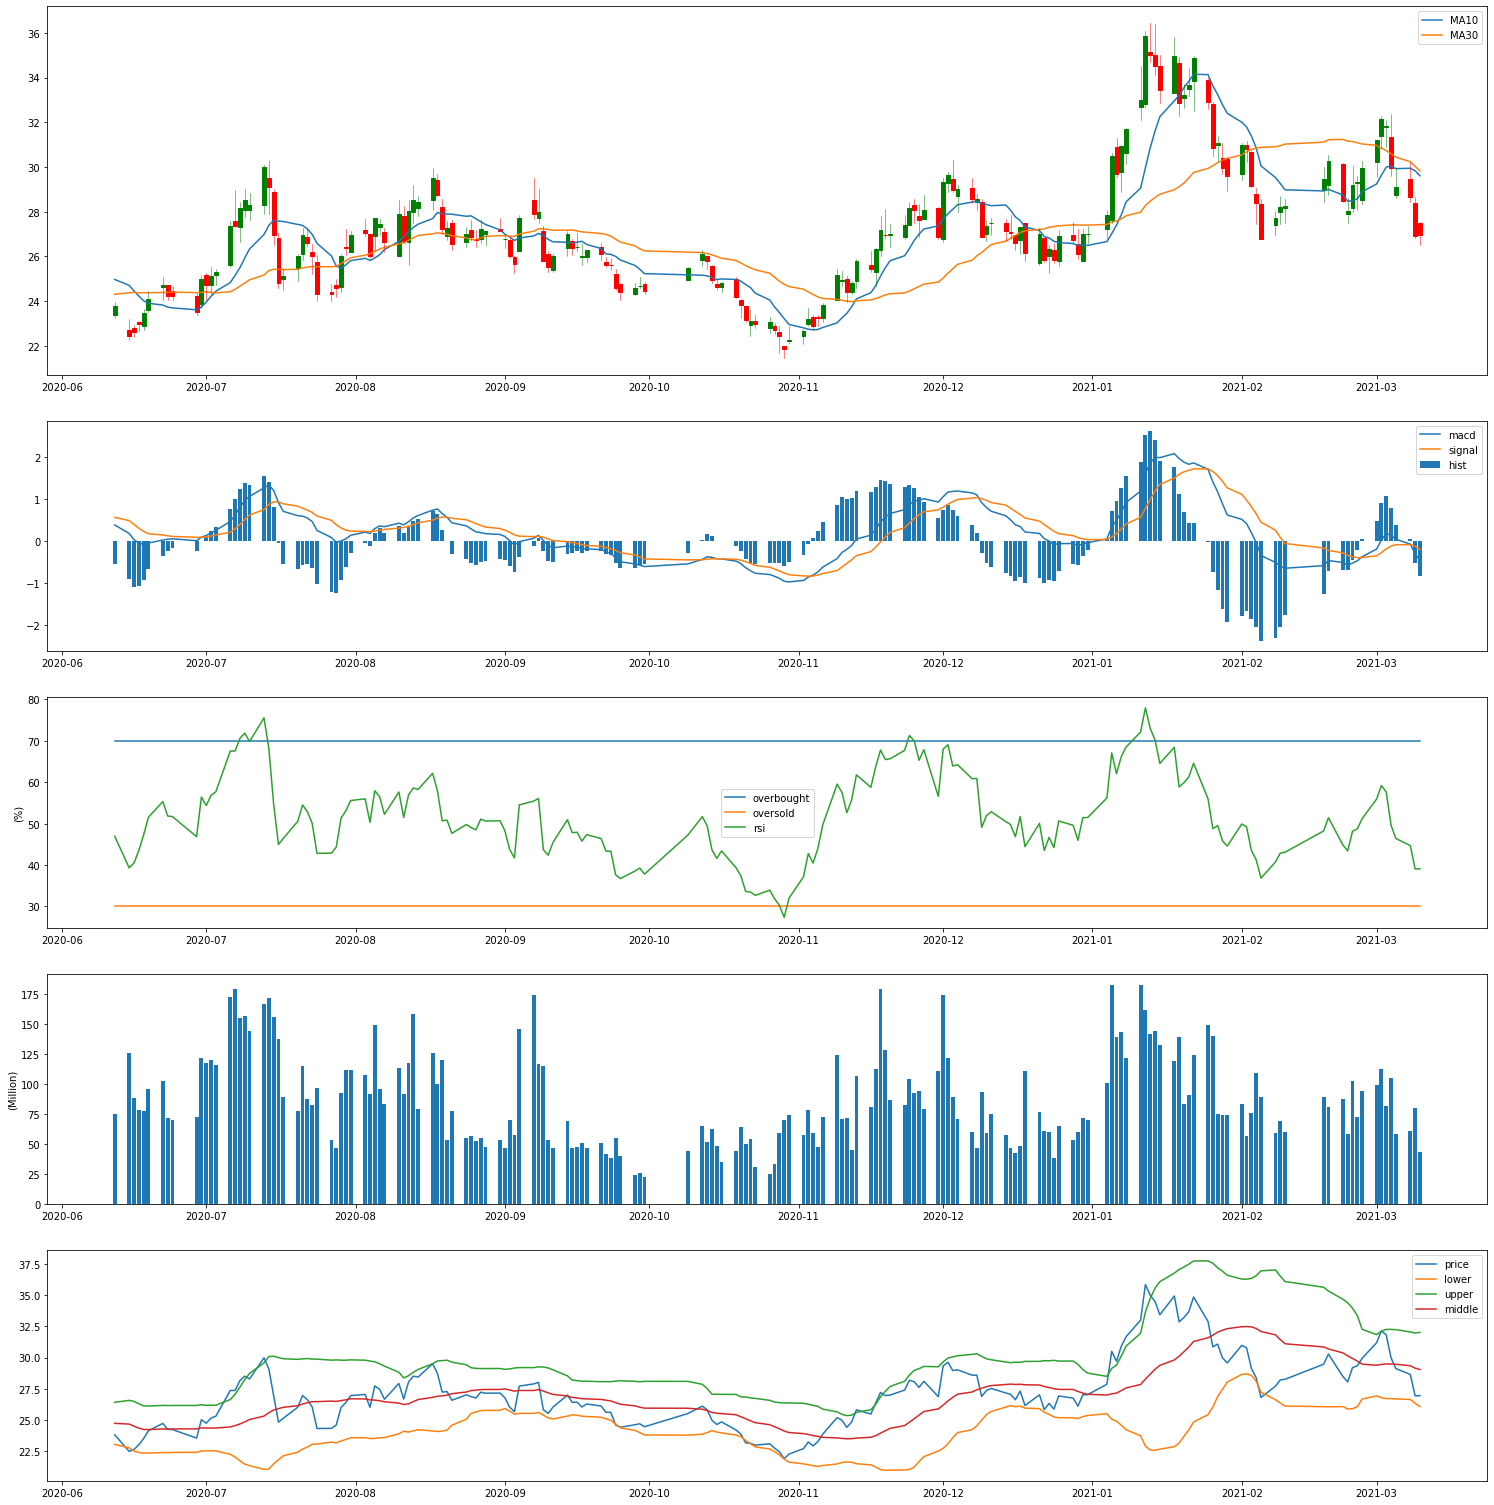

In [9]:

i=0
for stock in stock_name:
    ticker = stock_lst[i]
    df = dfs[i]
    df2 = get_indicators(df)
    os.chdir(stock)

    plot_chart(df2, 180, stock)
    
    os.chdir("..")
    i=i+1

## Fundamental Analysis

In [15]:
from datetime import datetime
import lxml
from lxml import html
import requests
import numpy as np
import pandas as pd

def get_page(url):
    # Set up the request headers that we're going to use, to simulate
    # a request by the Chrome browser. Simulating a request from a browser
    # is generally good practice when building a scraper
    headers = {
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3',
        'Accept-Encoding': 'gzip, deflate, br',
        'Accept-Language': 'en-US,en;q=0.9',
        'Cache-Control': 'max-age=0',
        'Pragma': 'no-cache',
        'Referrer': 'https://google.com',
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/77.0.3865.120 Safari/537.36'
    }

    return requests.get(url, headers=headers)

def parse_rows(table_rows):
    parsed_rows = []

    for table_row in table_rows:
        parsed_row = []
        el = table_row.xpath("./div")

        none_count = 0

        for rs in el:
            try:
                (text,) = rs.xpath('.//span/text()[1]')
                parsed_row.append(text)
            except ValueError:
                parsed_row.append(np.NaN)
                none_count += 1

        if (none_count < 4):
            parsed_rows.append(parsed_row)
            
    return pd.DataFrame(parsed_rows)

def clean_data(df):
    df = df.set_index(0) # Set the index to the first column: 'Period Ending'.
    df = df.transpose() # Transpose the DataFrame, so that our header contains the account names
    
    # Rename the "Breakdown" column to "Date"
    cols = list(df.columns)
    cols[0] = 'Date'
    df = df.set_axis(cols, axis='columns', inplace=False)
    
    numeric_columns = list(df.columns)[1::] # Take all columns, except the first (which is the 'Date' column)

    for column_index in range(1, len(df.columns)): # Take all columns, except the first (which is the 'Date' column)
        df.iloc[:,column_index] = df.iloc[:,column_index].str.replace(',', '') # Remove the thousands separator
        df.iloc[:,column_index] = df.iloc[:,column_index].astype(np.float64) # Convert the column to float64
        
    return df

def scrape_table(url):
    # Fetch the page that we're going to parse
    page = get_page(url);

    # Parse the page with LXML, so that we can start doing some XPATH queries
    # to extract the data that we want
    tree = html.fromstring(page.content)

    # Fetch all div elements which have class 'D(tbr)'
    table_rows = tree.xpath("//div[contains(@class, 'D(tbr)')]")
    
    # Ensure that some table rows are found; if none are found, then it's possible
    # that Yahoo Finance has changed their page layout, or have detected
    # that you're scraping the page.
    assert len(table_rows) > 0
    
    df = parse_rows(table_rows)
    df = clean_data(df)
        
    return df

In [16]:
def scrape(symbol):
    print('Attempting to scrape data for ' + symbol)

    df_balance_sheet = scrape_table('https://finance.yahoo.com/quote/' + symbol + '/balance-sheet?p=' + symbol)
    df_balance_sheet = df_balance_sheet.set_index('Date')

    df_income_statement = scrape_table('https://finance.yahoo.com/quote/' + symbol + '/financials?p=' + symbol)
    df_income_statement = df_income_statement.set_index('Date')
    
    df_cash_flow = scrape_table('https://finance.yahoo.com/quote/' + symbol + '/cash-flow?p=' + symbol)
    df_cash_flow = df_cash_flow.set_index('Date')
    
    df_joined = df_balance_sheet \
        .join(df_income_statement, on='Date', how='outer', rsuffix=' - Income Statement') \
        .join(df_cash_flow, on='Date', how='outer', rsuffix=' - Cash Flow') \
        .dropna(axis=1, how='all') \
        .reset_index()
            
    df_joined.insert(1, 'Symbol', symbol)
    
    return df_joined

In [17]:
def scrape_multi(symbols):
    return pd.concat([scrape(symbol) for symbol in symbols], sort=False)

In [18]:

i=0
for stock in stock_name:
    ticker = stock_lst[i]

    os.chdir(stock)
    try:
        df_combined = scrape_multi([ticker])
    except:
        next
    df_combined.to_csv('Financial statement.csv')
    os.chdir("..")
    i=i+1



Attempting to scrape data for 0981.HK


## Fundamental

In [20]:
import yahoo_fin.stock_info as si

In [21]:

i=0
for stock in stock_name:
    ticker = stock_lst[i]

    os.chdir(stock)
    try:
        quote_table = si.get_quote_table(ticker,dict_result=False)
    except:
        next
    quote_table.to_csv('Fundamental analysis.csv')
    os.chdir("..")
    i=i+1


## Sentiment Analysis

In [16]:
import time
import pandas
import re
import requests
from bs4 import BeautifulSoup
print ("Libraries imported")

#Tracks how much time the script runs
start = time.time()

# Variables needed
stocks = ['0700.HK','3606.HK','1211.HK','3690.HK','2800.HK','000001.SS','MU','ADBE','SPOT','LOW','TSLA','UNH','NFLX','9988.HK','SNOW','CRM']
soup2=0
news_found = 0
row=1
col=0

# Load and read excel input file
#file = pandas.read_excel('20160706 - missing earnings.xlsx')

# Results output file


#Stocks list creation
def extracting_values(file):
    values = file["stock"].dropna()
    global stocks
    stocks = values.tolist()
    print ("\nThe following stocks have been extracted and added to the stocks[] list: " + str(stocks))

# Creating soup objects in general
def making_soup(url):
    page = requests.get(url)
    global soup2
    soup2 = BeautifulSoup(page.content, 'html.parser')

#Going to related news article
def getting_latest_news():
    global soup1
    for headline in soup1.find_all('a', href=re.compile(str(stock).lower())):
        exact_news = []
        if str(stock) in headline.text:
            exact_news.append(headline['href'])
        else:
            pass
        global news_found
        if news_found == 0:
            pass
        elif news_found == 1:
            break

        # Getting text from target news articles
        for news in exact_news:
            making_soup(news)
            global col
            col = 5

            for text in soup2.find_all('p', text=re.compile ("last issued its earnings results")):
                print ("\nHere are the actual news lines for: " + str (stock))
                print (text)
                news_found = 1
                break

            for text in soup2.find_all('p', text=re.compile ("last issued its earnings data")):
                print ("\nHere are the actual news lines for: " + str (stock))
                print (text)
                news_found = 1
                break

            for text in soup2.find_all ('p', text=re.compile ("last announced its quarterly earnings results")):
                print ("\nHere are the actual news lines for: " + str (stock))
                print (text)
                news_found = 1
                break

            for text in soup2.find_all ('p', text=re.compile ("last released its quarterly earnings results")):
                print ("\nHere are the actual news lines for: " + str (stock))
                print (text)
                news_found = 1
                break

            for text in soup2.find_all ('p', text=re.compile ("last announced its earnings results")):
                print ("\nHere are the actual news lines for: " + str (stock))
                print (text)
                news_found = 1
                break

# Searching transcriptdaily.com website
def news_search_transcriptdaily():
    global news_found
    news_found =0
    url="https://transcriptdaily.com/?s=" + str(stock)
    page = requests.get(url)
    global soup1
    soup1 = BeautifulSoup(page.content,'lxml')
    print ("\nSearching Transcriptdaily for the target company: " + (str(stock)))


# Searching dailypolitical.com website
def news_search_dailypolitical():
    global news_found
    news_found == 0
    url = "https://www.dailypolitical.com/?s=" + str (stock)
    page = requests.get (url)
    soup1 = BeautifulSoup (page.content, 'lxml')
    print ("\nSearching Dailypolitical for the target company: " + (str (stock)))

    text = 'No news found'

# Searching rttnews.com website
def news_search_rttnews():
    for stock in stocks:
        news_found=0
        url="http://www.rttnews.com/symbolsearch.aspx?symbol=" + str(stock)
        page = requests.get(url)
        soup1 = BeautifulSoup(page.content,'lxml')
        print ("\nSearching RTT News for the target company: " + (str(stock)))

# Searching marketbeat.com website
def news_search_marketbeat():
    for stock in stocks:
        news_found=0
        url="https://www.marketbeat.com/stocks/" + str(stock)
        page = requests.get(url)
        soup1 = BeautifulSoup(page.content,'lxml')
        print ("\nSearching Marketbeat for the target company: " + (str(stock)))

# Code start
#extracting_values(file)  # to stocks list



Libraries imported


In [21]:
import re
import urllib.request
import pandas
from bs4 import BeautifulSoup

stocks = ['0700.HK','3606.HK','1211.HK','3690.HK','2800.HK','000001.SS','MU','ADBE','SPOT','LOW','TSLA','UNH','NFLX','9988.HK','SNOW','CRM','600031.SS']

#Going to news website for each stock.
for stock in stocks:
    news_found=0
    news_website="https://transcriptdaily.com/?s=" + str(stock)
    hdr = {'Accept': 'text/html,application/xhtml+xml,*/*',"user-agent":"Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/48.0.2564.116 Safari/537.36"}
    req=urllib.request.Request(news_website,headers=hdr)
    html = urllib.request.urlopen(req).read()
    soup = BeautifulSoup(html)
    print("\nLooking for news related to the target company: " + str(stock))
#Getting all news links    
    for link in soup.find_all('a', href=re.compile(str(stock).lower())):
        exact_news=[]
        exact_news.append(link['href'])
        if news_found==0:
            pass
        elif news_found==1:
            break
#Getting text from target news articles        
        for news in exact_news:
            news_text=0
            news_text=news
            req_news=urllib.request.Request(news_text,headers=hdr)
            html_news = urllib.request.urlopen(req_news).read()
            target_news_soup=BeautifulSoup(html_news)
            for text in target_news_soup.find_all('p', text=re.compile("last issued its earnings results")):
                print("\nHere are the actual news lines for: " + str(stock))
                print(text)
                news_found=1
            for text in target_news_soup.find_all('p', text=re.compile("last issued its earnings data")):
                print("\nHere are the actual news lines for: " + str(stock))
                print(text)
                news_found=1
print("\nAll done!")


Looking for news related to the target company: 0700.HK

Looking for news related to the target company: 3606.HK

Looking for news related to the target company: 1211.HK

Looking for news related to the target company: 3690.HK

Looking for news related to the target company: 2800.HK

Looking for news related to the target company: 000001.SS

Looking for news related to the target company: MU

Here are the actual news lines for: MU
<p>Saia (NASDAQ:SAIA) last issued its earnings results on Sunday, February 7th. The transportation company reported $1.51 earnings per share (EPS) for the quarter, topping the Thomson Reuters’ consensus estimate of $1.30 by $0.21. The business had revenue of $476.50 million during the quarter, compared to analyst estimates of $474.61 million. Saia had a return on equity of 13.63% and a net margin of 6.68%. Saia’s revenue for the quarter was up 7.5% on a year-over-year basis. During the same quarter in the prior year, the firm earned $0.81 earnings per share.

In [22]:
# Searching dailypolitical.com website
exact_news=[]
def news_search_dailypolitical():
 
    news_found == 0
    url = "https://www.dailypolitical.com/?s=" + str (stock)
    page = requests.get (url)
    soup1 = BeautifulSoup (page.content, 'lxml')
    print ("\nSearching Dailypolitical for the target company: " + (str (stock)))
    for link in soup.find_all('a', href=re.compile(str(stock).lower())):
        
        exact_news.append(link['href'])
        for news in exact_news:
            news_text=0
            news_text=news
            req_news=urllib.request.Request(news_text,headers=hdr)
            html_news = urllib.request.urlopen(req_news).read()
            target_news_soup=BeautifulSoup(html_news)
            for text in target_news_soup.find_all('a'):
                print(text)